# Predicting-Poker-Hand-Strength

## Introduction

### Background

Texas Hold’em is a popular variant of Poker. Between 2-8 players sit at a table and each player is dealt two face-down cards (called their “pocket”). Across 4 stages of betting, 5 face-up cards (called “community cards”) are played on the table. After the last stage of betting, remaining players reveal their pocket cards and make the best 5 card hand possible, using a combination of their own cards and the face-up community cards. The player with the best 5 card hand collects all the money bet by each of the players (called the “pot”) for that round. 

### Objective

The objective of this project was to predict the strength of a player’s two pocket cards, as determined by a hand strength formula known as the “Chen Formula”. 

### Methods

Data was obtained from the UofAlberta IRC Poker Database, which contained game logs for thousands of online poker players. First, Logistic Regression, Multinomial Naive Bayes and AdaBoost (Boosted) Decision Tree models were fit to the full set of player data and compared on their prediction accuracy. Then, the dataset was segmented by dividing players into different groups based on playing style using K-Means clustering. The best performing model from the first step was fit to each segment of the dataset corresponding to a particular player type. 

### Results

The AdaBoost (Boosted) Decision Tree model best fit the full set of player data, yielding a prediction accuracy of 41.5%. Fitting a separate AdaBoost (Boosted) Decision Tree model to each player type did not improve the prediction accuracy. 

## Data Processing and Visualization

In [1]:
## Importing all the necessary libraries
import pandas as pd
import numpy as np
import glob as glob
import os as os
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt
import re
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
import math
from yellowbrick.cluster import KElbowVisualizer

C:\Users\PAUL-2\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
## This function uses the glob module to retrieve the filenames of all files from a particular path which match a provided regex expression. 
## Each retrieved file is converted into a dataframe and each of the resulting dataframes are stored in a list. All the dataframes in the list are then concatenated together.
def concatenate_dataframes(path, regex, *names):
    files  = glob.glob(path + regex)
    file_list = []
    for filename in files:
        df = pd.read_csv(filename, delim_whitespace=True, header= None, names = list(names))
        file_list.append(df)
    dataframe = pd.concat(file_list, axis=0, ignore_index=True)
    return dataframe

In [3]:
## Apply the 'concatenate_dataframes' function on all the player database files and hands database files.
## The resulting dataframes are merged together on the 'game_id' column. 
players = concatenate_dataframes(r'C:\Users\PAUL-2\Desktop\199504', "/pdb*", 'player_name', 'game_id', '#_of_players', 'position', 'preflop', 'flop', 'turn', 'river', 'bankroll', 'total_bet', 'winnings', 'card_1', 'card_2')
hands = concatenate_dataframes(r'C:\Users\PAUL-2\Desktop\199504', "/hdb*", 'game_id', 'dealer', 'hand#', '#players', 'flop', 'turn', 'river', 'showdown', 'board_card_1', 'board_card_2', 'board_card_3', 'board_card_4', 'board_card_5')        

all_hands = pd.merge(players, hands, on = 'game_id')

### Understanding the Raw Data

This is what the original dataframe looks like:

In [4]:
all_hands

,player_name,game_id,#_of_players,position,preflop,flop_x,turn_x,river_x,bankroll,total_bet,winnings,card_1,card_2,dealer,hand#,#players,flop_y,turn_y,river_y,showdown,board_card_1,board_card_2,board_card_3,board_card_4,board_card_5
0,aaron,798243437,11,8,f,-,-,-,1000,0,0,NaN,NaN,5,3141,11,4/85,2/105,2/225,2/265,2c,Kd,Js,6h,Ks
1,an_idiot,798243437,11,4,r,b,br,b,830,110,0,Ts,Qs,5,3141,11,4/85,2/105,2/225,2/265,2c,Kd,Js,6h,Ks
2,BeesiTzu,798243437,11,7,c,f,-,-,1205,20,0,NaN,NaN,5,3141,11,4/85,2/105,2/225,2/265,2c,Kd,Js,6h,Ks
3,bharat,798243437,11,5,f,-,-,-,800,0,0,NaN,NaN,5,3141,11,4/85,2/105,2/225,2/265,2c,Kd,Js,6h,Ks
4,derek,798243437,11,6,f,-,-,-,2970,0,0,NaN,NaN,5,3141,11,4/85,2/105,2/225,2/265,2c,Kd,Js,6h,Ks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139751,}{,797323574,5,3,ccc,f,-,-,1000,40,0,NaN,NaN,3,836,5,4/160,3/250,3/310,2/350,4c,2c,Qs,9s,6s
139752,|-|-|-|,797323740,4,1,BQ,-,-,-,875,5,0,NaN,NaN,3,837,4,0/0,0/0,0/0,1/15,NaN,NaN,NaN,NaN,NaN
139753,_-_-_-_-,797323740,4,3,Q,-,-,-,1005,0,0,NaN,NaN,3,837,4,0/0,0/0,0/0,1/15,NaN,NaN,NaN,NaN,NaN
139754,_O_,797323740,4,4,f,-,-,-,1135,0,0,NaN,NaN,3,837,4,0/0,0/0,0/0,1/15,NaN,NaN,NaN,NaN,NaN


Each row represents a hand played by a given player in a given game. The important columns are interpreted as follows:

##### 'preflop', 'flop_x', 'turn_x' and 'river_x'

The string of characters underneath these columns represent betting actions by the player in the different stages of betting. The betting action is encoded with a single character for each action:

|  Character   |    Action    |
| ------------ | ------------ |
| - | no action; player is no longer contesting pot |
| B | blind bet |
| f | fold |
| k | check |
| b | bet |
| c | call |
| r | raise |
| A | all-in |
| Q | quits game |
| K | kicked from game |

##### 'bankroll'

Total amount available for a player to bet at the beginning of a round. 

##### 'card_1' and 'card_2'

If the player played until the showdown without folding, then their two pocket cards are shown under these two columns. 

##### 'flop_y', 'turn_y', 'river_y' and 'showdown'

The first number is the number of players remaining in the game at the start of the stage. The second number is the total pot size at the start of the stage (the showdown is when players reveal their cards; no betting happens at this stage). 

### Data Cleaning and Generating Features/Target Variable

In [5]:
## Dropping irrelevant columns from the dataframe
all_hands.drop(all_hands.columns[[2,3,10,13,14,15,20,21,22,23,24]], axis = 1, inplace=True)

#### Target Variable

In order to generate the target variable, the Chen formula was applied to the 'pocket' column. The Chen formula maps each hand to a hand strength value between -2 and 20. Rows with either a NaN value (player folded before the showdown) or the correct string format (e.g. '8s 9c') for a pocket hand were kept and any rows with an abhorrent pocket hand input were removed. 

In [6]:
## A new column is created which shows the two pocket cards of each hand, if available. 
all_hands["pocket"] = all_hands["card_1"] +" "+ all_hands["card_2"] 

In [7]:
all_hands['pocket']

0           NaN
1         Ts Qs
2           NaN
3           NaN
4           NaN
          ...  
139751      NaN
139752      NaN
139753      NaN
139754      NaN
139755      NaN
Name: pocket, Length: 139756, dtype: object

In [8]:
## This function is used to ensure all the pocket hands are in a correct format.
## The function returns False (hand is not corrupt) if the hand is either an NaN value, or if there is a full match between the hand and the regex expression that represents the following pattern: '8d Qs'. 
## The function returns True otherwise (hand is corrupt).
def check_corrupt_hand(hand):
    if (pd.isnull(hand) == True) or (re.fullmatch(r'\w[csdh]\s\w[csdh]', hand) != None):
        return False
    else:
        return True 

In [9]:
## Apply the 'check_corrupt_hand' function to the 'pocket' column and store the indices of any hands which are corrupt.
## The rows corresponding to the stored indices are dropped from the dataframe.
indices = all_hands[all_hands['pocket'].apply(check_corrupt_hand) == True].index
all_hands.drop(indices, inplace = True)

In [10]:
## This function will take the player's two pocket cards as input and return the corresponding hand strength. 
## If the two pocket cards are unavailable, the function returns NaN. 
def chen_formula(hand):
    if pd.isnull(hand) == True:
        return np.nan
    else:
        card_1, suite_1,  card_2, suite_2 = hand[0], hand[1], hand[3], hand[4]
        values = {'A' : 10, 'K' : 8, 'Q' : 7, 'J' : 6, 'T' : 5 , '9' : 4.5 , '8' : 4, '7' : 3.5, '6' : 3 , '5' : 2.5 , '4' : 2 , '3' : 1.5 , '2' : 1}
        values_list = list(values)
        differences = {0:0, 1:0, 2:1, 3:2, 4:4, 5:5, 6:5, 7:5, 8:5, 9:5, 10:5, 11:5, 12:5}
        hand_strength = max(values[card_1], values[card_2])
        if card_1 == card_2:
            hand_strength = (hand_strength)*2
            if card_1 in ('2','3','4'):
                hand_strength = 5
        if suite_1 == suite_2:
            hand_strength += 2
        hand_strength  = hand_strength - (differences[abs(values_list.index(card_1) - values_list.index(card_2))])
        if (values_list.index(card_1) and values_list.index(card_2)) > 2:
            if abs(values_list.index(card_1) - values_list.index(card_2)) in [1,2]:
                hand_strength += 1
        hand_strength = round(hand_strength)
        return hand_strength

In [11]:
## A new column will be created which shows the hand strength of the two pocket cards, if available. 
all_hands['hand_strength'] = all_hands['pocket'].apply(chen_formula)

In [12]:
all_hands['hand_strength']

0         NaN
1         8.0
2         NaN
3         NaN
4         NaN
         ... 
139751    NaN
139752    NaN
139753    NaN
139754    NaN
139755    NaN
Name: hand_strength, Length: 139756, dtype: float64

#### Features

##### Preflop, Flop, Turn and River -- Check/Bet/Call/Raise Counts

These features were counts of the number of times each betting action (call, check, raise and bet) was performed in each of the stages of betting (preflop, flop, turn and river). Any rows with null values for the betting actions were removed.

In [13]:
## This function checks if there is a null value where a string encoding a player's actions should be. 
def check_corrupt_actions(actions):
    if pd.isnull(actions) == True:
        return True
    else:
        return False

In [14]:
## Apply the check_corrupt_actions function to each betting actions column, and store the indices of any rows where there is a null value where the betting actions string should be. 
## The corresponding indices are dropped from the dataframe using the .drop function. 
for column in ['preflop', 'flop_x', 'turn_x', 'river_x']:
    indices = all_hands[all_hands[column].apply(check_corrupt_actions) == True].index
    all_hands.drop(indices, inplace = True)

In [15]:
## This function takes as input a particular betting stage and betting action and will return a count of how many times that action was performed in that stage.
## Actions in a stage are encoded in a string. The string is converted to a list and the number of occurences of a character (like 'k', which maps onto the action 'check') in the list are counted.
## For example, if during the preflop the player's actions were 'bc', the function would return a bet count of 1 and call count of 1.
def count_moves(stage, action):
    actions = {'check' : 'k', 'bet' : 'b', 'call': 'c', 'raise': 'r'}
    stage = list(stage)
    return stage.count(actions[action])

In [16]:
## New columns will be made which show the counts of each action in each stage of betting. This is done by applying the 'count_moves' function to the string of actions in a stage of bettng.
## For example, 'preflop_bet_count' and 'flop_raise_count' and 'turn_check_count'.
for column in ['preflop', 'flop_x', 'turn_x', 'river_x']:
    for action in ['check', 'bet', 'call', 'raise']:
        all_hands[column + '_' + action + '_' + 'count'] = all_hands[column].apply(count_moves, args = (action,))

In [17]:
all_hands.iloc[:,15:31]

,hand_strength,preflop_check_count,preflop_bet_count,preflop_call_count,preflop_raise_count,flop_x_check_count,flop_x_bet_count,flop_x_call_count,flop_x_raise_count,turn_x_check_count,turn_x_bet_count,turn_x_call_count,turn_x_raise_count,river_x_check_count,river_x_bet_count,river_x_call_count
0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8.0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0
2,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139751,NaN,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0
139752,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
139753,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
139754,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Total Check/Bet/Call/Raise Counts

These features were counts of the total number of times a player checked, called, raised or bet in a given hand. Each feature was generated by summing the counts for that particular betting action across all stages of betting. E.g. Total Call Count = preflop call count + flop call count + turn call count + river call count. 

In [18]:
## Create 4 new columns for the total check, bet, call and raise count of a hand. 
## Each column is created by summing the corresponding entries from the preflop, flop, turn and river betting action count columns. 
for action in ['check', 'bet', 'call', 'raise']:
    all_hands['total ' + action + ' ' + 'count'] = all_hands['preflop_' + action + '_' + 'count'] + all_hands['flop_x_' + action + '_' + 'count'] + all_hands['turn_x_' + action + '_' + 'count'] + all_hands['river_x_' + action + '_' + 'count']
    

In [19]:
all_hands.iloc[:,31:35]

,river_x_raise_count,total check count,total bet count,total call count
0,0,0,0,0
1,0,0,3,0
2,0,0,0,1
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
139751,0,0,0,3
139752,0,0,0,0
139753,0,0,0,0
139754,0,0,0,0


##### Total Bet

This feature is the total amount that a player bet across all 4 stages of betting. No data processing was needed for this feature as it came pre-recorded in the dataset. 

In [20]:
all_hands['total_bet']

0           0
1         110
2          20
3           0
4           0
         ... 
139751     40
139752      5
139753      0
139754      0
139755     10
Name: total_bet, Length: 139756, dtype: int64

##### Preflop, Flop, Turn and River Bet Amounts

These features were the amounts bet by a player in each particular stage of betting (preflop, flop, turn and river). First, a new dataframe, hands_without_fold, was created from the previous dataframe, all_hands, that only contains rows for which the two pocket cards were available as this is the data that the model will be trained on. This step was not performed earlier because the intention was to generate the betting action count features on all hands, folded or not, for use in the player clustering that will be performed later.

In [21]:
## Create a new dataframe that only features rows(hands) where the pocket cards available, ie. hands that a player played until the showdown without folding.
hands_without_fold = all_hands.dropna(subset = ['card_1', 'card_2'])

In [22]:
hands_without_fold['hand_strength']

1          8.0
6          8.0
26        14.0
31         5.0
36         9.0
          ... 
139720     6.0
139744     5.0
139745     6.0
139747     6.0
139749     2.0
Name: hand_strength, Length: 24267, dtype: float64

In [23]:
## This function takes as input a string of the form 'players/pot' and will return the bet amount for each player by divding the pot by the number of players.
## This function is specifically for calculating the players bets in the preflop stage of betting. 
def preflop_bet(flop_y):
    preflop = flop_y.split('/', 1)
    preflop_pot = int(preflop[1])
    players = int(preflop[0])
    try:
        bet = (preflop_pot/players)
    except ZeroDivisionError:
        return np.nan
    return bet

In [24]:
## A new column is created that shows the preflop bet amount for each hand. 
hands_without_fold['preflop_bet'] = hands_without_fold['flop_y'].apply(preflop_bet)

C:\Users\PAUL-2\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
## This function is similar to the 'preflop_bet' function. It takes as input strings of the form 'players/pot' from a prior stage of betting and a subsequent stage of betting.
## The bet amount for each player in the subsequent stage is calculated by subtracting the total pot at the end of the prior stage from the total pot at the end of the subsequent stage and dividing by the number of players in the subsequent stage.
## This function will be used to calculate player bet amounts for the flop, turn and river stages of betting. 
def bet_amount(stage1, stage2):
    stage2 = stage2.split('/', 1)
    stage2_bet_total = int(stage2[1])
    stage2_players = int(stage2[0])
    stage1 = stage1.split('/', 1)
    stage1_bet_total = int(stage1[1])
    stage2_pot = stage2_bet_total - stage1_bet_total

    try:
        player_bet = (stage2_pot/stage2_players)
    except ZeroDivisionError:
        return np.nan
    return player_bet

In [26]:
## New columns will be created that show the player bet amounts for the flop, turn and river stages of betting for each hand.
for group in [['flop_y', 'turn_y'], ['turn_y', 'river_y'],['river_y', 'showdown']]:
    stage1 = group[0] 
    stage = group[0][0:-2]
    stage2 = group[1]
    hands_without_fold[stage + '_' + 'bet'] = hands_without_fold.apply(lambda x: bet_amount(x[stage1], x[stage2]), axis=1)

C:\Users\PAUL-2\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
hands_without_fold.loc[:,['preflop_bet', 'flop_bet', 'turn_bet', 'river_bet']]

,preflop_bet,flop_bet,turn_bet,river_bet
1,21.25,10.0,60.0,20.0
6,21.25,10.0,60.0,20.0
26,25.00,35.0,20.0,20.0
31,25.00,35.0,20.0,20.0
36,20.00,10.0,20.0,20.0
...,...,...,...,...
139720,30.00,20.0,60.0,20.0
139744,42.50,10.0,20.0,20.0
139745,42.50,10.0,20.0,20.0
139747,40.00,30.0,20.0,20.0


After generating all the new columns, rows with NaN values for any of the bet amounts were identified. There are rows which have NaN values for the preflop, flop or river bet. Rows with NaN values for the preflop or flop bet occur because one of the players went all-in and the game went straight to the showdown, causing the number of players and pot size at each stage of betting to be registered as "0/0" for each player's hand. Rows with NaN values for the river bet occur either because of the aforementioned reason or because the player quit the game during the river. The two pocket cards are still shown for a hand if the player quit at the river, which explains why these rows weren't dropped when the folded hands were filtered out. Hands where a player quit at the river or hands in a game where a player went all-in cannot be used in the analysis because they have an incomplete set of betting actions or betting amounts or both. Fortunately, such hands are only a small percentage of the dataset, so they can be dropped from the dataframe with little consequence to the model fit.

In [28]:
hands_without_fold[pd.isnull(hands_without_fold['total_bet'])]

,player_name,game_id,preflop,flop_x,turn_x,river_x,bankroll,total_bet,card_1,card_2,flop_y,turn_y,river_y,showdown,pocket,hand_strength,preflop_check_count,preflop_bet_count,preflop_call_count,preflop_raise_count,flop_x_check_count,flop_x_bet_count,flop_x_call_count,flop_x_raise_count,turn_x_check_count,turn_x_bet_count,turn_x_call_count,turn_x_raise_count,river_x_check_count,river_x_bet_count,river_x_call_count,river_x_raise_count,total check count,total bet count,total call count,total raise count,preflop_bet,flop_bet,turn_bet,river_bet


In [29]:
hands_without_fold[pd.isnull(hands_without_fold['preflop_bet'])].head(100)

,player_name,game_id,preflop,flop_x,turn_x,river_x,bankroll,total_bet,card_1,card_2,flop_y,turn_y,river_y,showdown,pocket,hand_strength,preflop_check_count,preflop_bet_count,preflop_call_count,preflop_raise_count,flop_x_check_count,flop_x_bet_count,flop_x_call_count,flop_x_raise_count,turn_x_check_count,turn_x_bet_count,turn_x_call_count,turn_x_raise_count,river_x_check_count,river_x_bet_count,river_x_call_count,river_x_raise_count,total check count,total bet count,total call count,total raise count,preflop_bet,flop_bet,turn_bet,river_bet
1578,ab0,797497487,Brr,-,-,-,1585,40,Kh,Ts,0/0,0/0,2/70,2/70,Kh Ts,6.0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,NaN,NaN,35.0,0.0
1579,d_h,797497487,BrA,-,-,-,30,30,5s,4h,0/0,0/0,2/70,2/70,5s 4h,4.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,35.0,0.0
87734,DanSal,798434952,cA,-,-,-,10,10,Jh,Jd,0/0,0/0,2/45,2/45,Jh Jd,12.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,NaN,NaN,22.5,0.0
87736,Schween,798434952,r,-,-,-,4200,20,5c,As,0/0,0/0,2/45,2/45,5c As,5.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,22.5,0.0
97410,comet2,798044345,BcA,-,-,-,20,20,7h,9h,0/0,0/0,2/40,2/40,7h 9h,6.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,NaN,NaN,20.0,0.0
97411,kr,798044345,Br,-,-,-,1910,20,Js,Th,0/0,0/0,2/40,2/40,Js Th,7.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,20.0,0.0
97412,comet2,798044351,BrrA,-,-,-,40,40,As,2h,0/0,0/0,2/90,2/90,As 2h,5.0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,NaN,NaN,45.0,0.0
97413,kr,798044351,Brr,-,-,-,1890,50,Ah,Ks,0/0,0/0,2/90,2/90,Ah Ks,10.0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,NaN,NaN,45.0,0.0
109026,greg,798363468,B,-,-,-,2364,10,2c,Ks,0/0,0/0,2/25,2/25,2c Ks,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,12.5,0.0
109030,rktbot2,798363468,cA,-,-,-,10,10,Th,Kh,0/0,0/0,2/25,2/25,Th Kh,8.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,NaN,NaN,12.5,0.0


In [30]:
hands_without_fold[pd.isnull(hands_without_fold['flop_bet'])].head(100)

,player_name,game_id,preflop,flop_x,turn_x,river_x,bankroll,total_bet,card_1,card_2,flop_y,turn_y,river_y,showdown,pocket,hand_strength,preflop_check_count,preflop_bet_count,preflop_call_count,preflop_raise_count,flop_x_check_count,flop_x_bet_count,flop_x_call_count,flop_x_raise_count,turn_x_check_count,turn_x_bet_count,turn_x_call_count,turn_x_raise_count,river_x_check_count,river_x_bet_count,river_x_call_count,river_x_raise_count,total check count,total bet count,total call count,total raise count,preflop_bet,flop_bet,turn_bet,river_bet
1578,ab0,797497487,Brr,-,-,-,1585,40,Kh,Ts,0/0,0/0,2/70,2/70,Kh Ts,6.0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,NaN,NaN,35.000000,0.0
1579,d_h,797497487,BrA,-,-,-,30,30,5s,4h,0/0,0/0,2/70,2/70,5s 4h,4.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,35.000000,0.0
2205,Borgbug,797553064,c,b,-,-,1272,20,Kc,7c,3/21,0/0,2/31,2/31,Kc 7c,5.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,7.000000,NaN,15.500000,0.0
2208,jf0,797553064,BA,-,-,-,1,1,6h,8d,3/21,0/0,2/31,2/31,6h 8d,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.000000,NaN,15.500000,0.0
30280,jaxter,798170782,r,rr,-,-,490,60,Kh,Kd,3/70,0/0,2/154,2/154,Kh Kd,16.0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,3,23.333333,NaN,77.000000,0.0
30282,Quick,798170782,c,rcA,-,-,54,54,Jd,Qc,3/70,0/0,2/154,2/154,Jd Qc,7.0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,2,1,23.333333,NaN,77.000000,0.0
59043,IFR,797293015,cc,bcA,-,-,35,35,4d,Ad,7/145,0/0,2/180,2/180,4d Ad,7.0,0,0,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,3,0,20.714286,NaN,90.000000,0.0
59045,Nova,797293015,r,r,-,-,1080,40,9d,8c,7/145,0/0,2/180,2/180,9d 8c,6.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,20.714286,NaN,90.000000,0.0
82461,brillo,798147013,cc,bcA,-,-,35,35,8d,6d,5/100,0/0,2/135,2/135,8d 6d,6.0,0,0,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,3,0,20.000000,NaN,67.500000,0.0
82464,miyake,798147013,r,r,-,-,1315,40,Kd,Kc,5/100,0/0,2/135,2/135,Kd Kc,16.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,20.000000,NaN,67.500000,0.0


In [31]:
hands_without_fold[pd.isnull(hands_without_fold['turn_bet'])]

,player_name,game_id,preflop,flop_x,turn_x,river_x,bankroll,total_bet,card_1,card_2,flop_y,turn_y,river_y,showdown,pocket,hand_strength,preflop_check_count,preflop_bet_count,preflop_call_count,preflop_raise_count,flop_x_check_count,flop_x_bet_count,flop_x_call_count,flop_x_raise_count,turn_x_check_count,turn_x_bet_count,turn_x_call_count,turn_x_raise_count,river_x_check_count,river_x_bet_count,river_x_call_count,river_x_raise_count,total check count,total bet count,total call count,total raise count,preflop_bet,flop_bet,turn_bet,river_bet


In [32]:
hands_without_fold[pd.isnull(hands_without_fold['river_bet'])].head(100)

,player_name,game_id,preflop,flop_x,turn_x,river_x,bankroll,total_bet,card_1,card_2,flop_y,turn_y,river_y,showdown,pocket,hand_strength,preflop_check_count,preflop_bet_count,preflop_call_count,preflop_raise_count,flop_x_check_count,flop_x_bet_count,flop_x_call_count,flop_x_raise_count,turn_x_check_count,turn_x_bet_count,turn_x_call_count,turn_x_raise_count,river_x_check_count,river_x_bet_count,river_x_call_count,river_x_raise_count,total check count,total bet count,total call count,total raise count,preflop_bet,flop_bet,turn_bet,river_bet
40816,alfalfa,798732143,Bc,kc,k,kcQ,275,40,Jc,7c,2/20,2/40,2/40,0/80,Jc 7c,4.0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,3,0,3,0,10.0,10.0,0.0,NaN
40817,deadhead,798732143,Bk,b,k,bQ,925,40,5h,Js,2/20,2/40,2/40,0/80,5h Js,1.0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,2,2,0,0,10.0,10.0,0.0,NaN
126848,itkas,799138941,Br,b,b,rrrrrrrrrrrrrrcA,620,620,6d,8h,2/40,2/60,2/100,0/1250,6d 8h,4.0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,14,0,2,1,15,20.0,10.0,20.0,NaN
126849,Kurtz,799138941,Bcc,kc,kc,brrrrrrrrrrrrrrQ,2014,630,Jh,6h,2/40,2/60,2/100,0/1250,Jh 6h,3.0,0,0,2,0,1,0,1,0,1,0,1,0,0,1,0,14,2,1,4,14,20.0,10.0,20.0,NaN


In [33]:
## Using the df.dropna function to remove any rows for which any of the bet amount values are NaN. 
hands_without_fold.dropna(subset = ['total_bet', 'preflop_bet', 'flop_bet', 'turn_bet', 'river_bet'], inplace=True)

C:\Users\PAUL-2\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Visualizing Features and Target Variable

In [34]:
## A function which returns a bar plot of the distribution of the values in a particular column, i.e. essentially a histogram of the spread of a particular variable.
def plot_distribution_with_stats(df, column, xlabel, ylabel, title):
    array = df[column].to_numpy()
    array = array[~np.isnan(array)]
    labels, counts = np.unique(array, return_counts=True)
    plt.bar(labels, counts, align='center')
    plt.gca().set_xticks(labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    print(column + ' ' + 'mean is ' + str(df[column].mean()))
    print(column + ' ' + 'median is ' + str(df[column].median()))
    print(column + ' ' + 'standard deviation is ' + str(df[column].std()))
    print('\n')
    

#### Target Variable

From the plot it can be seen that a hand strength of 5 is most common and that most hand strengths fall in the range between 2 and 10. The mean, median and standard deviation for the hand strengths are 6.13, 6.0 and 3.57 respectively.

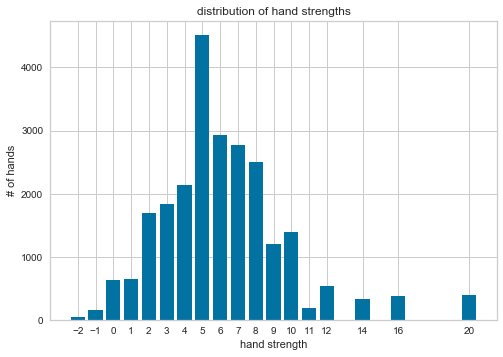

hand_strength mean is 6.136440433510528
hand_strength median is 6.0
hand_strength standard deviation is 3.5718435948834757




In [35]:
plot_distribution_with_stats(all_hands, 'hand_strength', 'hand strength', '# of hands', 'distribution of hand strengths')

#### Features

For each feature, the spread was visualized and then hand strength was plotted against that feature to see if there was any relationship between the two. All of the features were discrete variables, so the average hand strength of all hands corresponding to a particular value of the feature was plotted against possible values of the feature. 

##### Preflop, Flop, Turn and River -- Check/Bet/Call/Raise Counts

###### Spread

The check count features in all stages of betting follow a bernoulli distribution. A check count of 0 in the preflop is far more common than a check count of 1, but the proportion of hands with a check count of 1 steadily increases until the river, where it is roughly half.

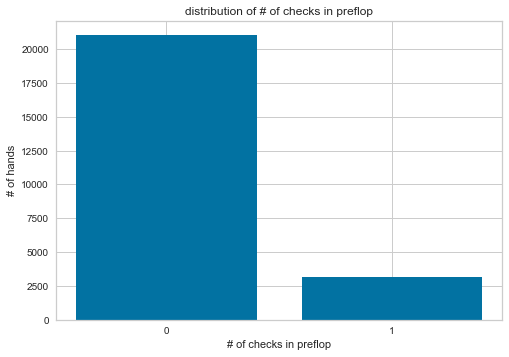

preflop_check_count mean is 0.1305479791718324
preflop_check_count median is 0.0
preflop_check_count standard deviation is 0.3369122959839517




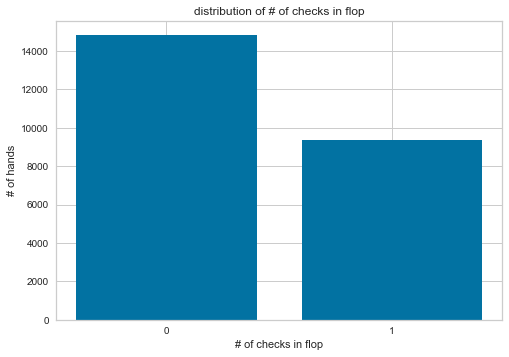

flop_x_check_count mean is 0.3874287131167865
flop_x_check_count median is 0.0
flop_x_check_count standard deviation is 0.4871729811014701




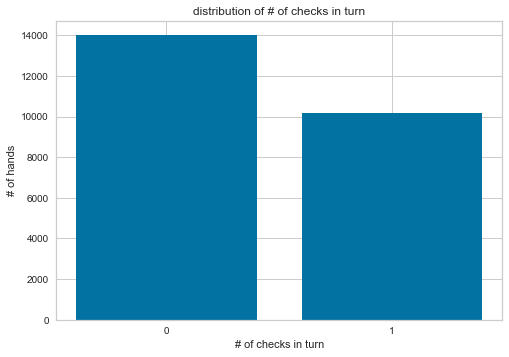

turn_x_check_count mean is 0.42110918257707247
turn_x_check_count median is 0.0
turn_x_check_count standard deviation is 0.4937472162691248




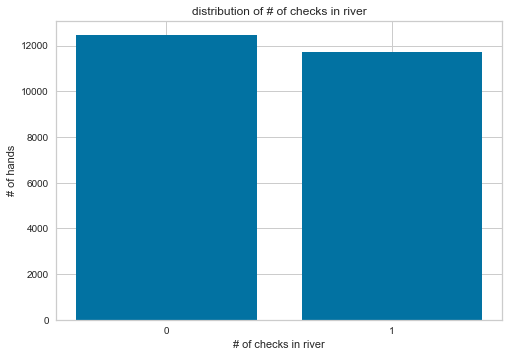

river_x_check_count mean is 0.48499876022811805
river_x_check_count median is 0.0
river_x_check_count standard deviation is 0.49978523924216356




In [36]:
for column in ['preflop', 'flop_x', 'turn_x', 'river_x']:
    for action in ['check']:
        stage = re.match('[a-z]{2,7}', column).group(0)
        plot_distribution_with_stats(hands_without_fold, column + '_' + action + '_' + 'count', '# of' + ' ' + action + 's in' + ' ' + stage, '# of hands', 'distribution of' + ' ' + '# of' + ' ' + action + 's in' + ' ' + stage)
        

Aside from the preflop, the bet count features in all stages of betting follow a bernoulli distribution and the number of hands with bet counts of 0 are about double the number of hands with bet counts of 1. In hindsight, it makes sense that all the preflop bet counts are 0 as there are small blind and big blind bets at the start of the preflop.

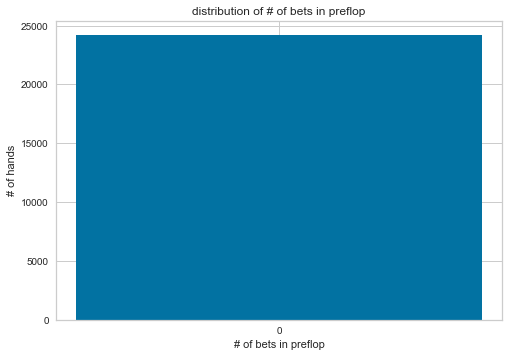

preflop_bet_count mean is 0.0
preflop_bet_count median is 0.0
preflop_bet_count standard deviation is 0.0




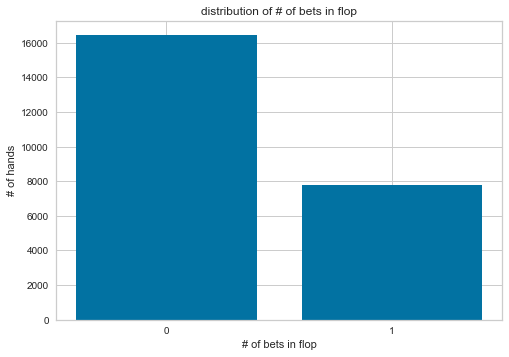

flop_x_bet_count mean is 0.32043970576080666
flop_x_bet_count median is 0.0
flop_x_bet_count standard deviation is 0.46665522617558475




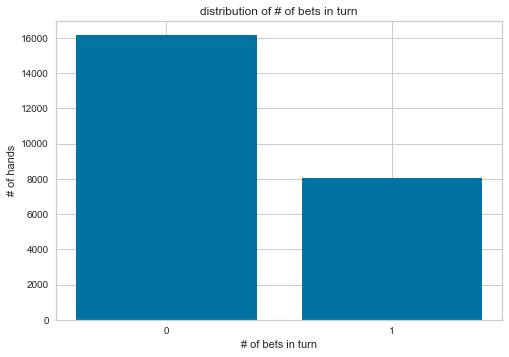

turn_x_bet_count mean is 0.33234151582775434
turn_x_bet_count median is 0.0
turn_x_bet_count standard deviation is 0.471062419278341




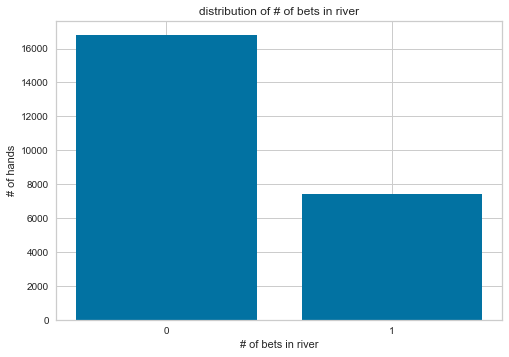

river_x_bet_count mean is 0.30601702620051247
river_x_bet_count median is 0.0
river_x_bet_count standard deviation is 0.46084637636512116




In [37]:
for column in ['preflop', 'flop_x', 'turn_x', 'river_x']:
    for action in ['bet']:
        stage = re.match('[a-z]{2,7}', column).group(0)
        plot_distribution_with_stats(hands_without_fold, column + '_' + action + '_' + 'count', '# of' + ' ' + action + 's in' + ' ' + stage, '# of hands', 'distribution of' + ' ' + '# of' + ' ' + action + 's in' + ' ' + stage)

Since the preflop bet count variable has 0 variance, it will be excluded from the model. 

In [38]:
hands_without_fold.drop(columns = ['preflop_bet_count'], inplace = True)

C:\Users\PAUL-2\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


The call count features in all stages of betting roughly follow a poisson distribution. From the preflop to the river, the spreads of the call count features decrease and the means decrease towards 0.

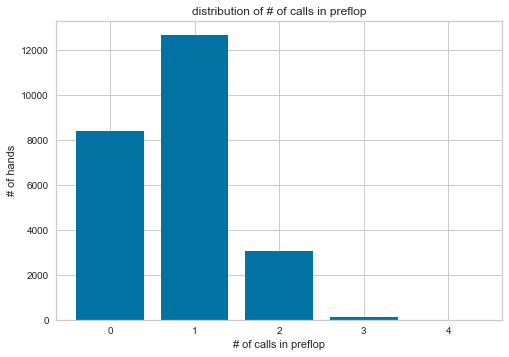

preflop_call_count mean is 0.7887015455822796
preflop_call_count median is 1.0
preflop_call_count standard deviation is 0.6688454671285119




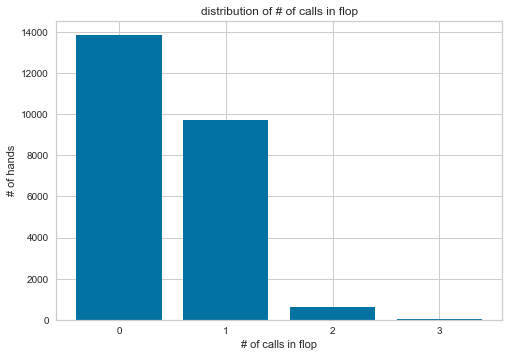

flop_x_call_count mean is 0.45615340110752955
flop_x_call_count median is 0.0
flop_x_call_count standard deviation is 0.5555097626127061




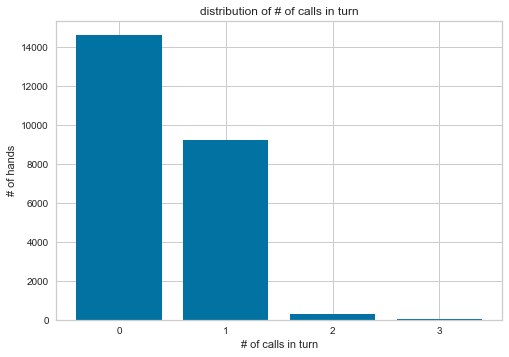

turn_x_call_count mean is 0.4103644929333003
turn_x_call_count median is 0.0
turn_x_call_count standard deviation is 0.5226244955982574




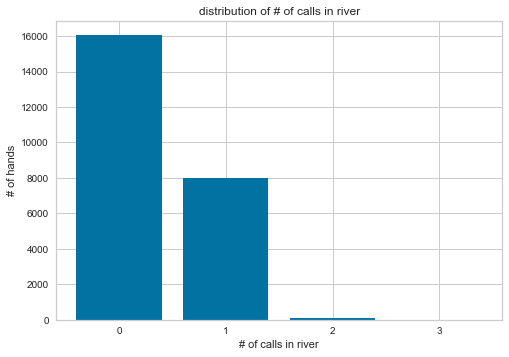

river_x_call_count mean is 0.3419290850483511
river_x_call_count median is 0.0
river_x_call_count standard deviation is 0.48632490440721604




In [39]:
for column in ['preflop', 'flop_x', 'turn_x', 'river_x']:
    for action in ['call']:
        stage = re.match('[a-z]{2,7}', column).group(0)
        plot_distribution_with_stats(hands_without_fold, column + '_' + action + '_' + 'count', '# of' + ' ' + action + 's in' + ' ' + stage, '# of hands', 'distribution of' + ' ' + '# of' + ' ' + action + 's in' + ' ' + stage)

From the spread of the preflop, flop, turn and river raise count features, it can be seen that there are potential high leverage points that could impact the fit of the logistic regression model. Unfortunately, there aren't any python tools with which one can systematically detect and remove influential points from a multinomial logistic regression fit. Instead of trying to remove these points to improve the logistc regression fit, other models which are simply more robust to the presence of outliers and high leverage points will be fit to the data as well. 

The raise count features in all stages of betting roughly follow a poisson distribution. From the preflop to the river, the spreads of the raise count features remain roughly the but and the means decrease towards zero.



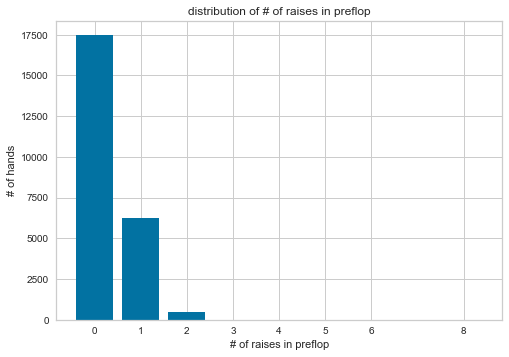

preflop_raise_count mean is 0.3015538474254071
preflop_raise_count median is 0.0
preflop_raise_count standard deviation is 0.5185552192869728




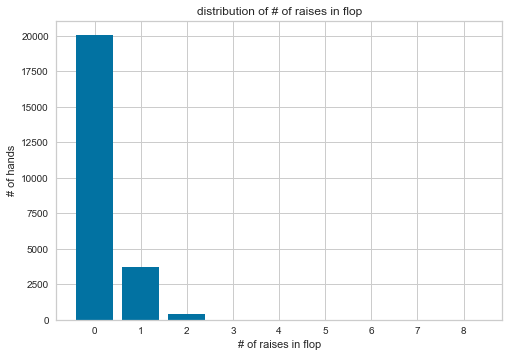

flop_x_raise_count mean is 0.1922886188941235
flop_x_raise_count median is 0.0
flop_x_raise_count standard deviation is 0.4591995213054852




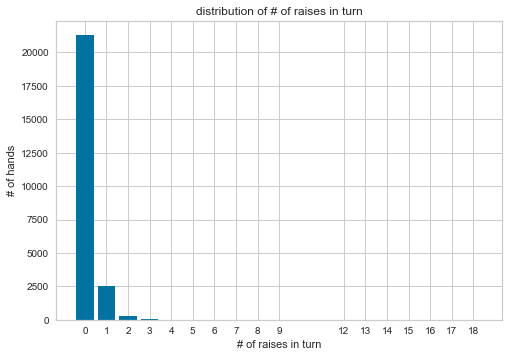

turn_x_raise_count mean is 0.1432349780973634
turn_x_raise_count median is 0.0
turn_x_raise_count standard deviation is 0.506499785516105




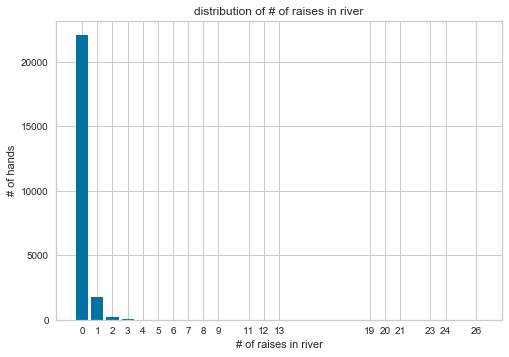

river_x_raise_count mean is 0.12145631870402512
river_x_raise_count median is 0.0
river_x_raise_count standard deviation is 0.6436364497614587




In [40]:
for column in ['preflop', 'flop_x', 'turn_x', 'river_x']:
    for action in ['raise']:
        stage = re.match('[a-z]{2,7}', column).group(0)
        plot_distribution_with_stats(hands_without_fold, column + '_' + action + '_' + 'count', '# of' + ' ' + action + 's in' + ' ' + stage, '# of hands', 'distribution of' + ' ' + '# of' + ' ' + action + 's in' + ' ' + stage)

###### Relationship to Hand Strength

In [42]:
## A function which returns a plot (bar or line, in this case) of a particular discrete variable feature against the average value of a response variable at each value of that discrete variable feature.
def plot_feature_with_response_var(df, column, response_var, agg_func, plot_type, rot, ymax, y_increments, xlabel, ylabel, title):
    grouped = df.groupby([column]).agg({response_var: agg_func})
    grouped.plot(kind = plot_type, legend = False, grid = True, rot = rot)
    plt.gca().set_yticks(np.linspace(start = 0.0, stop = ymax, num = y_increments))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title (title)
    mean = df[response_var].mean()
    plt.axhline(mean, color = 'r', linestyle = '--')
    plt.show()
 
    

There is a strong negative relationship between checking in the preflop and average pocket hand strength. There is a moderately negative relationship between checking in the flop, turn and river stages and average hand strength.

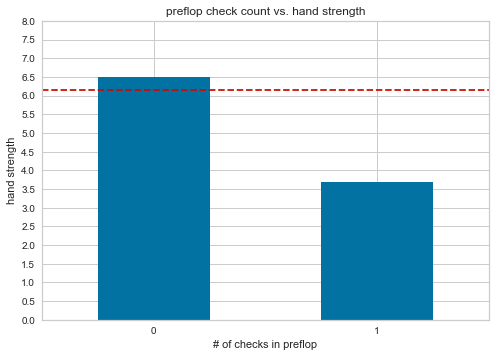

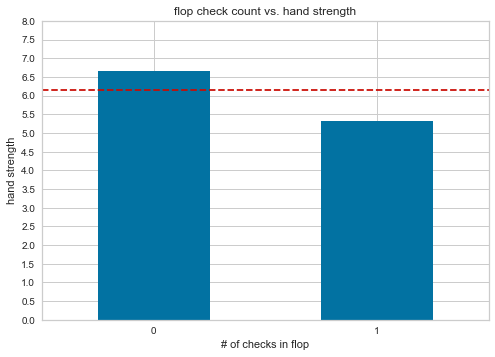

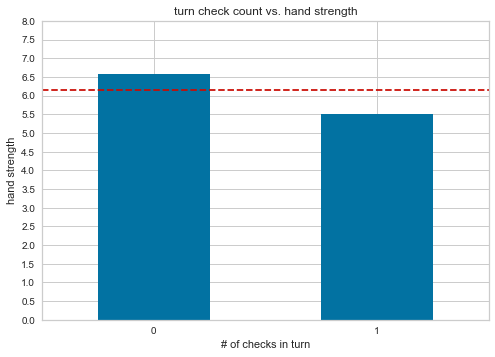

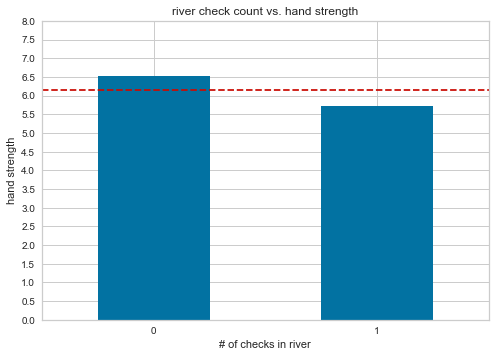

In [43]:
for column in ['preflop', 'flop_x', 'turn_x', 'river_x']:
    for action in ['check']:
        stage = re.match('[a-z]{2,7}', column).group(0)
        plot_feature_with_response_var(hands_without_fold, column + '_' + action + '_' + 'count', 'hand_strength', 'mean', 'bar', 0, 8, 17, '# of' + ' ' + action + 's in' + ' ' + stage, 'hand strength', stage + ' ' + action + ' ' + 'count' + ' ' + 'vs. hand strength')

There is a moderately positive relationship between betting in the flop and turn stages and average hand strength. There is a weakly positive relationship between betting in the river and average hand strength. 

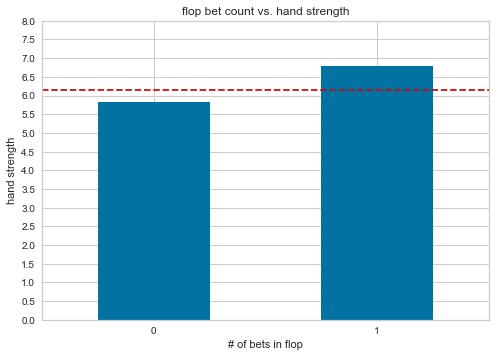

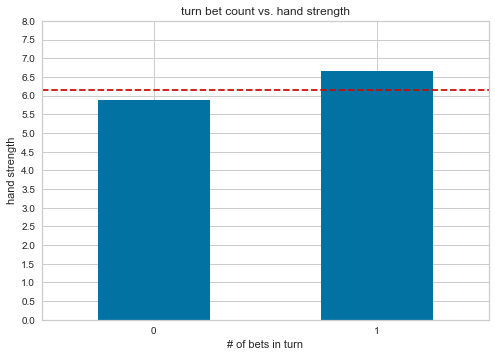

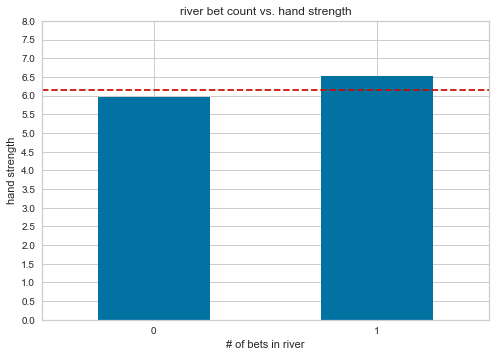

In [44]:
for column in ['flop_x', 'turn_x', 'river_x']:
    for action in ['bet']:
        stage = re.match('[a-z]{2,7}', column).group(0)
        plot_feature_with_response_var(hands_without_fold, column + '_' + action + '_' + 'count', 'hand_strength', 'mean', 'bar', 0, 8, 17, '# of' + ' ' + action + 's in' + ' ' + stage, 'hand strength', stage + ' ' + action + ' ' + 'count' + ' ' + 'vs. hand strength')

There is a roughly linear and negative relationship between calling in the preflop and average hand strength. Average hand strength decreases from 0 to 3 calls in the preflop, but increases between 3 and 4 calls. However, there is low confidence that average hand strength really does increase after 3 calls as the sample size of hands with 3 or more calls in the preflop is very small.  There is no relationship between calling in the flop and hand strength. There is a weakly positive linear relationship between call count in the turn and average hand strength. There is a moderately positive linear relationship between river call count and average hand strength up until 2 calls. Between 2 and 3 calls, average hand strength goes back down, but again, there is low confidence in this result since the sample size of hands with 2 or more calls in the river is small. 

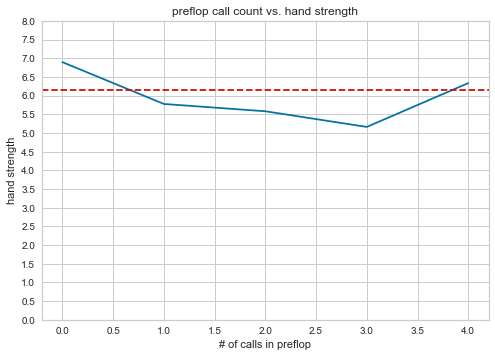

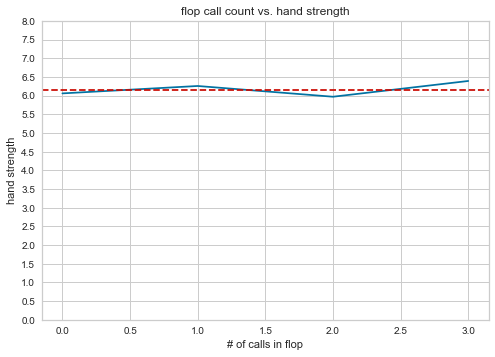

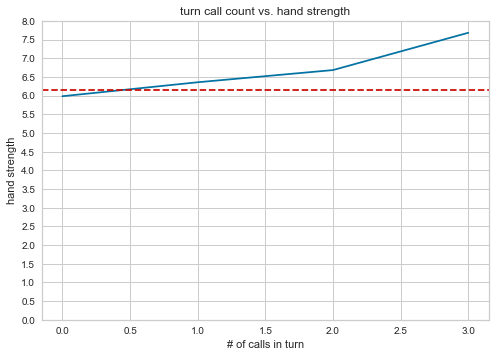

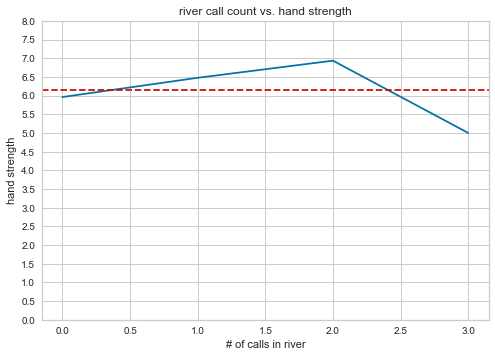

In [45]:
for column in ['preflop', 'flop_x', 'turn_x', 'river_x']:
    for action in ['call']:
        stage = re.match('[a-z]{2,7}', column).group(0)
        plot_feature_with_response_var(hands_without_fold, column + '_' + action + '_' + 'count', 'hand_strength', 'mean', 'line', 0, 8, 17, '# of' + ' ' + action + 's in' + ' ' + stage, 'hand strength', stage + ' ' + action + ' ' + 'count' + ' ' + 'vs. hand strength')

There are no clear relationships between the raise count features and average hand strength when the total range of raise counts for each stage of betting are plotted.

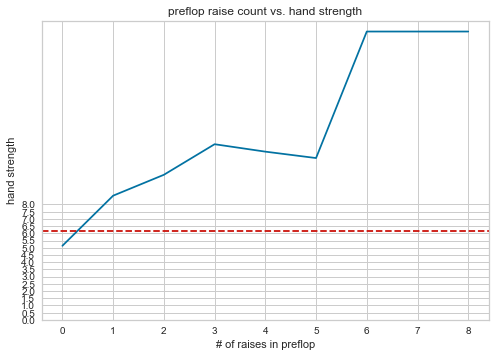

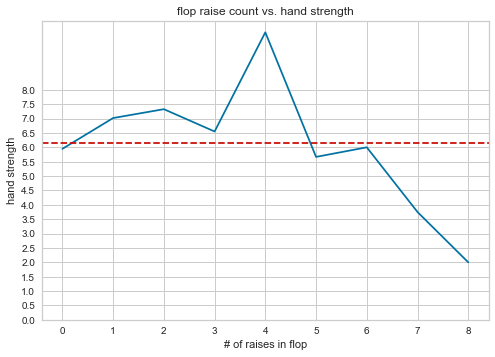

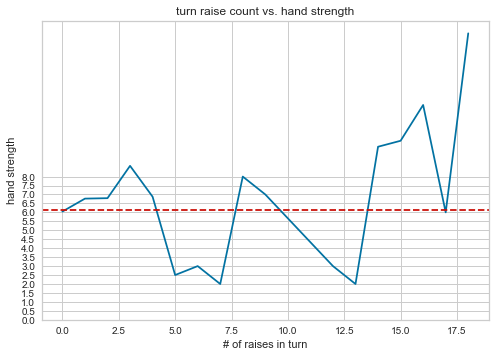

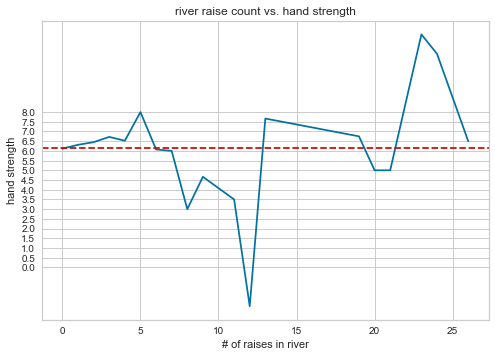

In [46]:
for column in ['preflop', 'flop_x', 'turn_x', 'river_x']:
    for action in ['raise']:
        stage = re.match('[a-z]{2,7}', column).group(0)
        plot_feature_with_response_var(hands_without_fold, column + '_' + action + '_' + 'count', 'hand_strength', 'mean', 'line', 0, 8, 17, '# of' + ' ' + action + 's in' + ' ' + stage, 'hand strength', stage + ' ' + action + ' ' + 'count' + ' ' + 'vs. hand strength')

When plotting raise counts in the range of 0-3 raises against average hand strength, some relationships emerge. In the preflop stage, there is a strong positive linear relationship between number of raises and average hand strength. In the flop, average hand strength increases linearly with the raise count up until 2 raises. It seems to decrease after 2 raises, but there is low confidence in this result because the sample size of hands with flop raise counts above 2 is small. In the turn, average hand strength goes up slightly between 0 and 1 raise, but there is no clear relationship between average hand strength and additional raises thereafter. There is low confidence in the relationship between average hand strength and raise count in the turn after 1 raise as the sample size of hands with more than 1 raise in the turn is small. In the river stage, there is no relationship between number of raises and average hand strength. 

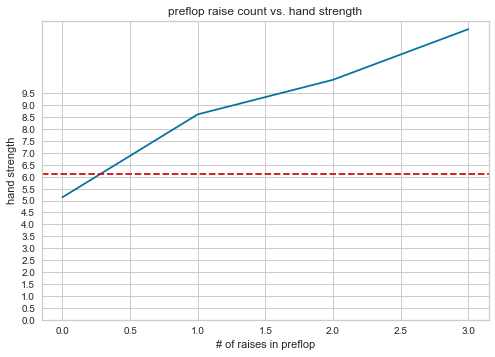

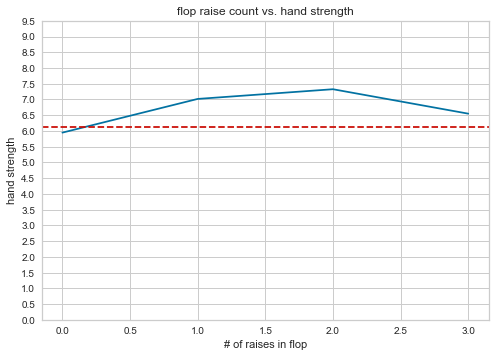

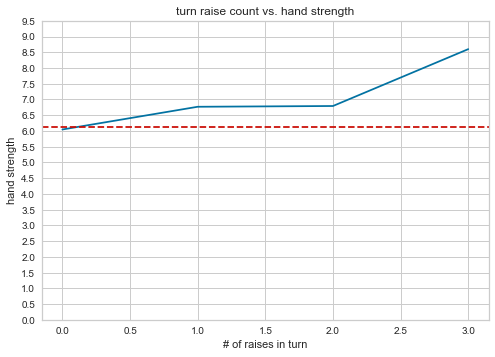

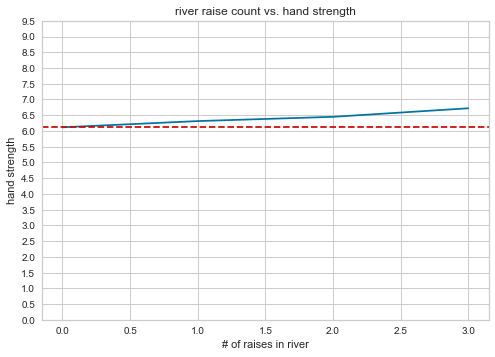

In [47]:
for column in ['preflop', 'flop_x', 'turn_x', 'river_x']:
    stage = re.match('[a-z]{2,7}', column).group(0)
    plot_feature_with_response_var(hands_without_fold[hands_without_fold[column + '_' + 'raise' + '_' + 'count'] <= 3], column + '_' + 'raise' + '_' + 'count', 'hand_strength', 'mean', 'line', 0, 9.5, 20, '# of' + ' ' + 'raises in' + ' ' + stage, 'hand strength', stage + ' ' + 'raise' + ' ' + 'count' + ' ' + 'vs. hand strength')
    
    

##### Total Check/Bet/Call/Raise Counts

###### Spread

All of the total betting action count features roughly follow a poisson distribution. Each feature has roughly the same spread, with the total call count feature showing the most spread and the total bet count feature showing the least. Calling appears to be the most common betting action. There are also a number of potential high leverage points for the total raise count feature. 

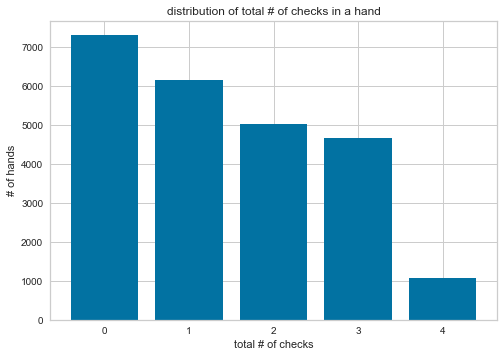

total check count mean is 1.4240846350938094
total check count median is 1.0
total check count standard deviation is 1.2245853118677796




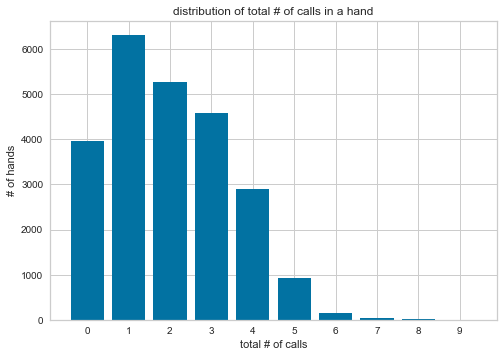

total call count mean is 1.9971485246714604
total call count median is 2.0
total call count standard deviation is 1.453538594294984




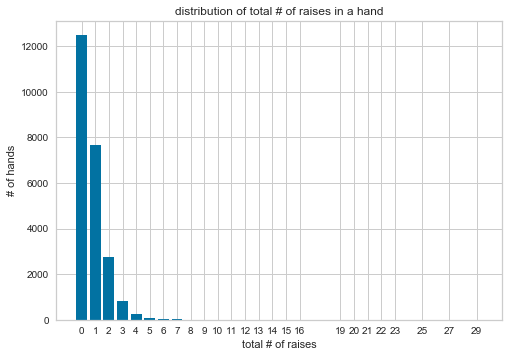

total raise count mean is 0.7585337631209191
total raise count median is 0.0
total raise count standard deviation is 1.2012122236356881




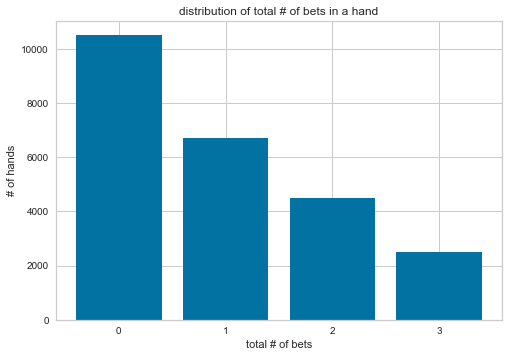

total bet count mean is 0.9587982477890735
total bet count median is 1.0
total bet count standard deviation is 1.0162526399247525




In [48]:
for column in ['total check count', 'total call count', 'total raise count', 'total bet count']:
    plot_distribution_with_stats(hands_without_fold, column, 'total # of ' + column[6:-6] + 's', '# of hands', 'distribution of total # of ' + column[6:-6] + 's in a hand')

###### Relationship to Hand Strength

There is a strong negative linear relationship between a player's total check count and average hand strength. 

There is no clear relationship between total call count and average hand strength.

There is no clear relationship between the total raise count feature and average hand strength when plotting the entire range of total raise count values.

There is a moderate positive linear relationship between total bet count and average hand strength.


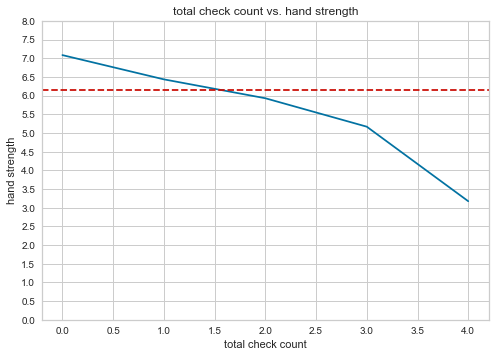

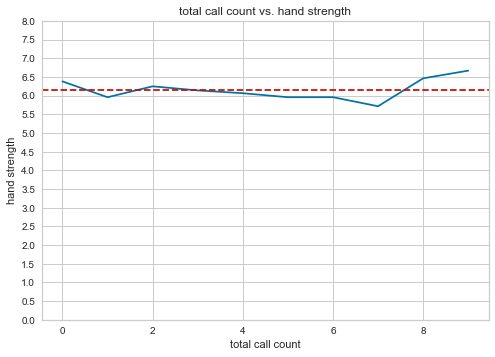

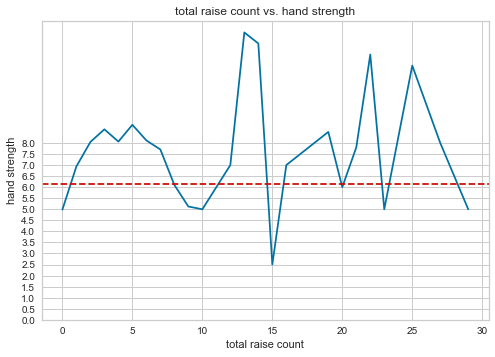

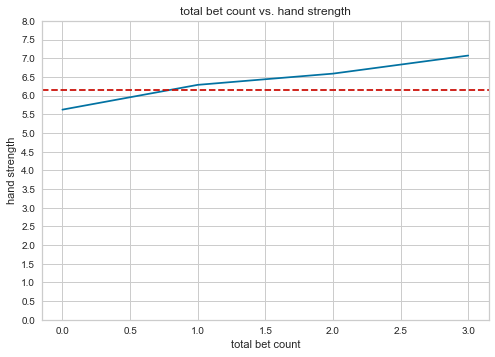

In [49]:
for column in ['total check count', 'total call count', 'total raise count', 'total bet count']:
    plot_feature_with_response_var(hands_without_fold, column, 'hand_strength', 'mean', 'line', 0, 8.0, 17, column, 'hand strength', column + ' vs. ' + 'hand strength')

In restricting the plot to only show total raise counts in the range of 0 and 4 raises, a fairly strong positive linear relationship between average hand strength and the total raise count can be seen.

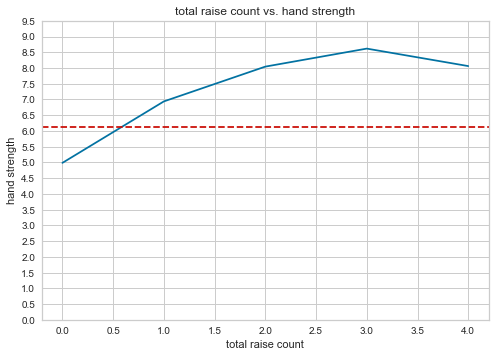

In [50]:
plot_feature_with_response_var(hands_without_fold[hands_without_fold['total raise count'] <= 4], 'total raise count', 'hand_strength', 'mean', 'line', 0, 9.5, 20, 'total raise count', 'hand strength', 'total raise count vs. hand strength')

##### Total Bet

In [51]:
## A function which returns a bar plot of the distribution of the values in a particular column, i.e. essentially a histogram of the spread of a particular variable.
## This function is specifically for discrete variables with high cardinality that need to be broken down into bins.
## The np.linspace function is returning an array of evenly spaced numbers over the interval (min value of column of interest, max value of column of interest).
## The pd.cut function sorts the column's values into the bins defined by the 'bins' variable, which is the output of the np.linspace function. 
def plot_distribution_with_bins_with_stats(df, column, bin_increments, rot, figsize, round_to, y_increments, xlabel, ylabel, title):
    bins = np.linspace(start = df[column].astype(dtype=int).min(), stop = df[column].astype(dtype=int).max(), num = bin_increments)
    grouped = df.groupby(pd.cut(df[column].astype(dtype=int), bins=bins)).size()
    grouped.plot.bar(legend=False, rot = rot, figsize = figsize)
    plt.gca().set_yticks(np.linspace(start = 0.0, stop = (math.ceil((grouped.max())/round_to))*round_to, num = y_increments))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    print(column + ' ' + 'mean is ' + str(df[column].astype(dtype=int).mean()))
    print(column + ' ' + 'median is ' + str(df[column].astype(dtype=int).median()))
    print(column + ' ' + 'standard deviation is ' + str(df[column].astype(dtype=int).std()))
    print('\n')

In [52]:
## Convert the 'total bet' column into an int datatype so arithmetic operations can be performed on it. 
hands_without_fold['total_bet'] = hands_without_fold['total_bet'].astype(dtype=int)

C:\Users\PAUL-2\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


###### Spread

A number of very high leverage points can be seen in plotting the spread of the total bet amounts. Nearly all the total bets amounts are below 180 and an overwhelming majority of them are lower than 120. 

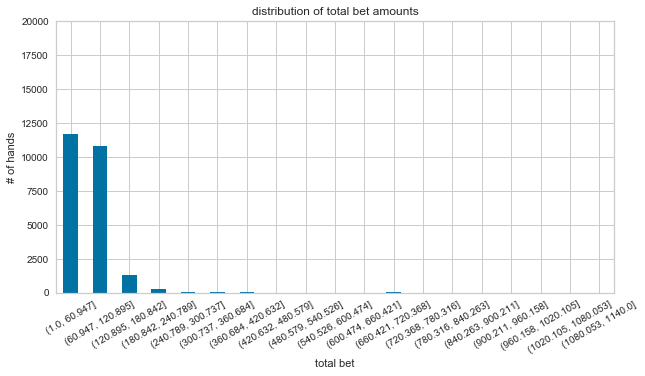

total_bet mean is 69.23489544590463
total_bet median is 70.0
total_bet standard deviation is 46.94190425691203




In [55]:
plot_distribution_with_bins_with_stats(hands_without_fold, 'total_bet', 20, 30, (10,5), 10000, 9, 'total bet', '# of hands', 'distribution of total bet amounts')

To get a view of the spread without the high leverage points, the distribution of total bet amounts for bet amounts lower than 180 is plotted. It can be seen that total bets in the rage of 65 to 75 are most common, but overall there is a lot of spread in the distribution of the total bet amounts -- the standard deviation of total bet amounts is around half the mean/median of the distribution.  

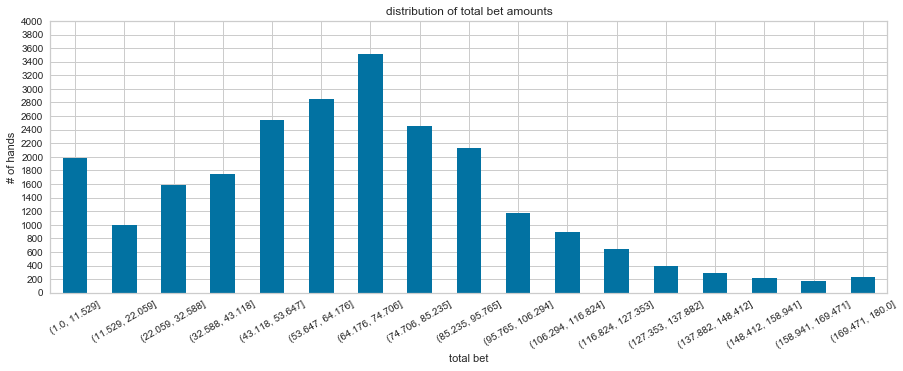

total_bet mean is 66.10237905425251
total_bet median is 70.0
total_bet standard deviation is 34.323206468980146




In [59]:
plot_distribution_with_bins_with_stats(hands_without_fold[hands_without_fold['total_bet'].astype(dtype=int) <= 180], 'total_bet', 18, 30, (15,5), 1000, 21, 'total bet', '# of hands', 'distribution of total bet amounts')

###### Relationship to Hand Strength

In [60]:
## A function which returns a plot (bar or line, in this case) of a particular discrete variable feature against the average value of a response variable at each range of values (bin) of that discrete variable feature.
## This function is specifically for discrete variables with high cardinality that need to be broken down into bins.
## The np.linspace function is returning an array of evenly spaced numbers over the interval (min value of column of interest, max value of column of interest).
## The pd.cut function sorts the column's values into the bins defined by the 'bins' variable, which is the output of the np.linspace function. 
def plot_feature_with_bins_with_response_var(df, column, bin_increments, response_var, agg_func, plot_type, rot, figsize, round_to, y_increments, xlabel, ylabel, title):
    bins = np.linspace(start = df[column].astype(dtype=int).min(), stop = df[column].astype(dtype=int).max(), num = bin_increments)
    grouped = df.groupby(pd.cut(df[column].astype(dtype=int), bins=bins)).agg({response_var: agg_func})
    grouped.plot(kind = plot_type, legend=False, grid= True, rot = rot, figsize = figsize)
    plt.gca().set_yticks(np.linspace(start = 0.0, stop = (math.ceil((grouped.max())/round_to))*round_to, num = y_increments))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    mean = df[response_var].mean()
    plt.axhline(mean, color = 'r', linestyle = '--')
    plt.show()

There is no clear relationship between total bet amount and average hand strength when plotting the entire range of total bet amount values. 

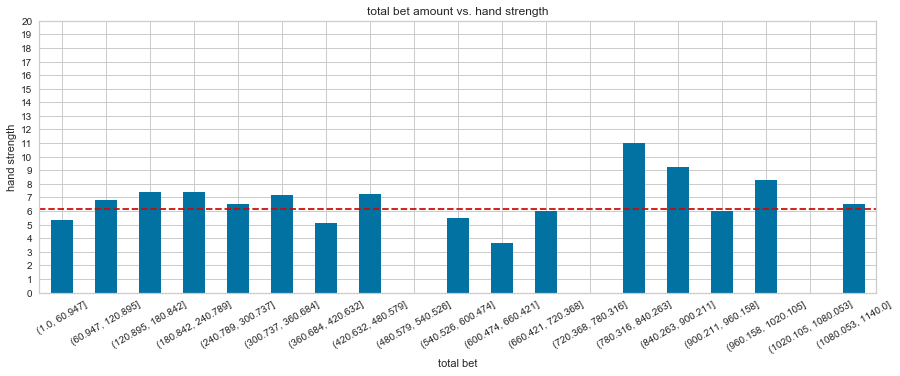

In [61]:
plot_feature_with_bins_with_response_var(hands_without_fold, 'total_bet', 20, 'hand_strength', 'mean', 'bar', 30, (15,5), 10, 21, 'total bet', 'hand strength', 'total bet amount vs. hand strength')

In plotting total bet amounts in the range of 0-250 against average hand strength, a non-linear relationship emerges. Up until a total bet amount of approximately 120, a linear and positive relationship between total bet amount and average hand strength is seen. After a total bet of 120, average hand strength seems to mostly level off and doesn't change with the total bet amount.

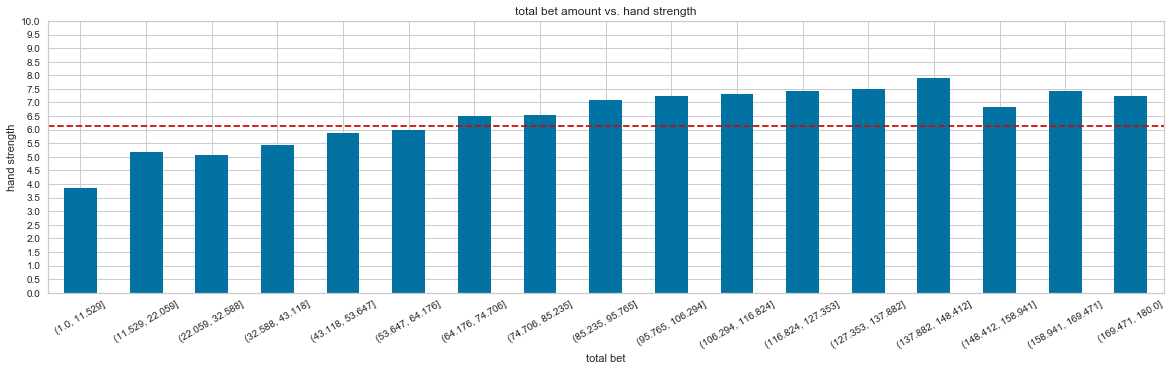

In [63]:
plot_feature_with_bins_with_response_var(hands_without_fold[hands_without_fold['total_bet'].astype(dtype=int) <= 180], 'total_bet', 18, 'hand_strength', 'mean', 'bar', 30, (20,5), 10, 21, 'total bet', 'hand strength', 'total bet amount vs. hand strength')

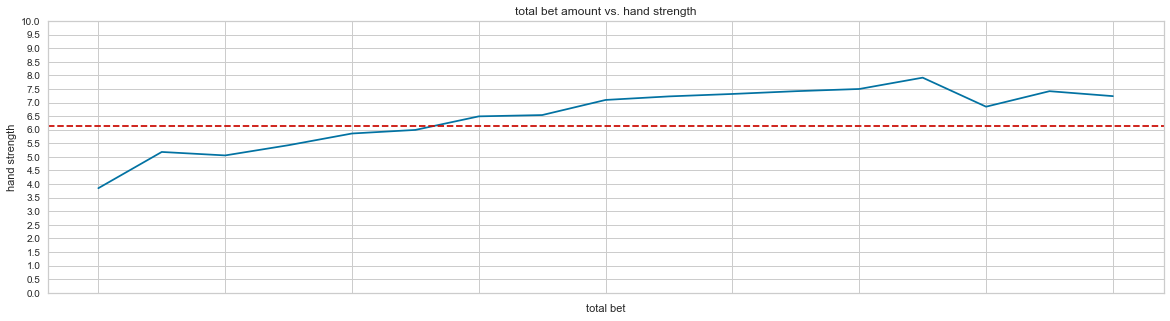

In [64]:
plot_feature_with_bins_with_response_var(hands_without_fold[hands_without_fold['total_bet'].astype(dtype=int) <= 180], 'total_bet', 18, 'hand_strength', 'mean', 'line', 30, (20,5), 10, 21, 'total bet', 'hand strength', 'total bet amount vs. hand strength')

##### Preflop, Flop, Turn and River Bet Amounts

###### Spread

In plotting the spread of the bet amount features it can be seen that there are many high leverage points in the data. 

Nearly all the preflop and flop bets are below a bet amount of 50 and nearly all the turn and river bets are below a bet amount of 115. 

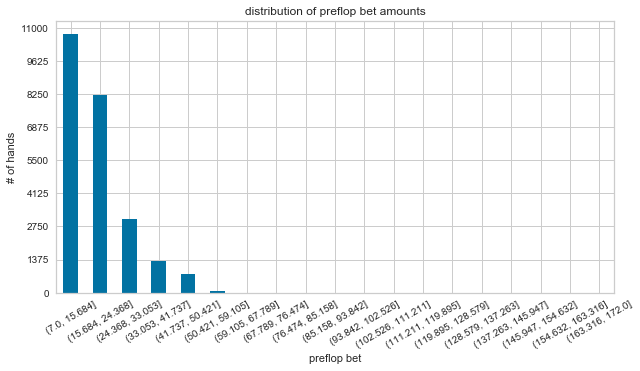

preflop_bet mean is 19.015373171336474
preflop_bet median is 20.0
preflop_bet standard deviation is 10.033963650917068




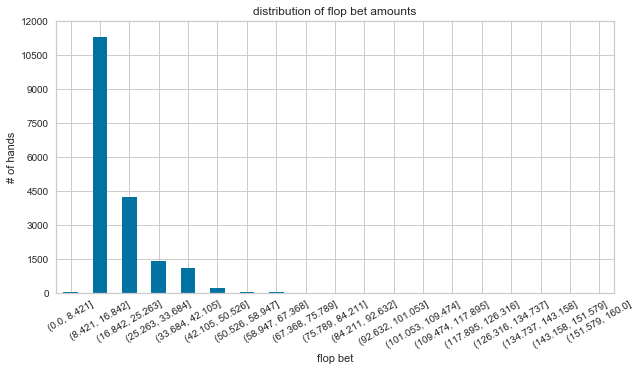

flop_bet mean is 12.37308868501529
flop_bet median is 10.0
flop_bet standard deviation is 11.240314084414283




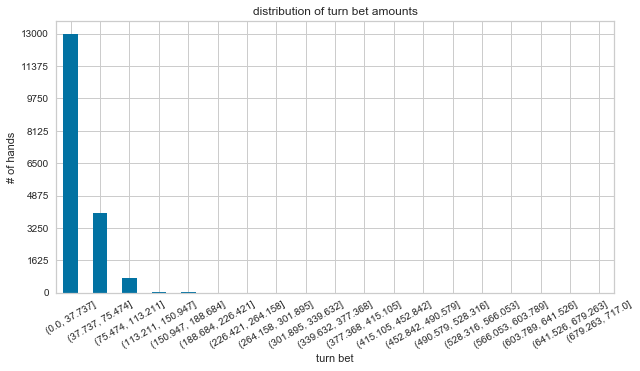

turn_bet mean is 21.238904041656337
turn_bet median is 20.0
turn_bet standard deviation is 23.226292701043004




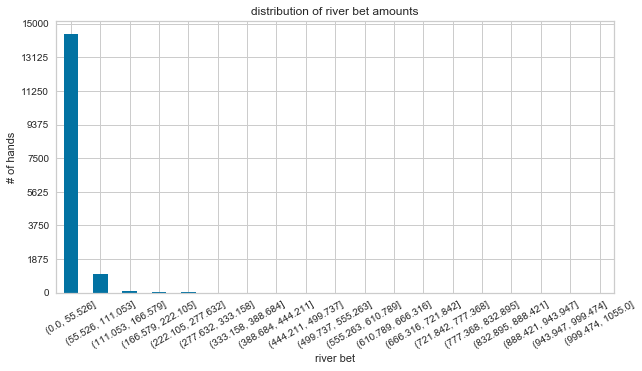

river_bet mean is 18.16137697330358
river_bet median is 20.0
river_bet standard deviation is 28.412509347042658




In [73]:
for column in ['preflop_bet', 'flop_bet', 'turn_bet', 'river_bet']:
    plot_distribution_with_bins_with_stats(hands_without_fold, column, 20, 30, (10,5), 1000, 9, column[0:-4] + ' bet', '# of hands', 'distribution of ' + column[0:-4] + ' bet amounts')

To visualize the spread of the bet amounts by betting stage without the high leverage points, the distribution plots are restricted to only show bets in the range of 0-115.

All 4 features show modest spread, with the turn bet amount showing the most. Clearly, the spreads of the bet amounts in the individual stages of betting are lower than the spread seen with the total bet amount. The preflop and flop bet amount distributions show similar spread, but the average bet amount in the preflop is double the average in the flop. The turn and river bet amount distributions are nearly identical.

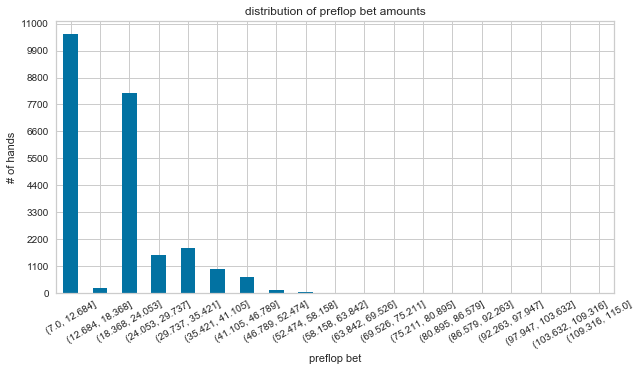

preflop_bet mean is 18.98569775132275
preflop_bet median is 20.0
preflop_bet standard deviation is 9.849453894959098




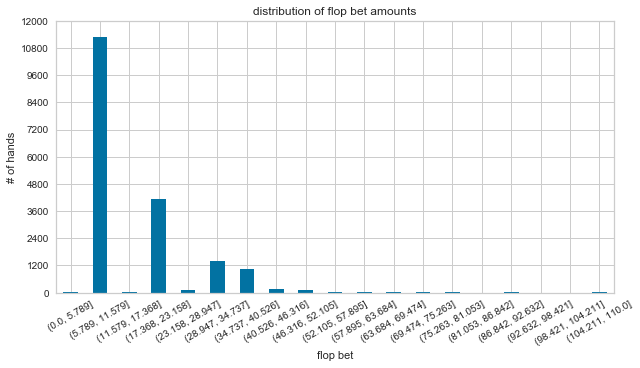

flop_bet mean is 12.338955026455027
flop_bet median is 10.0
flop_bet standard deviation is 11.029977020425026




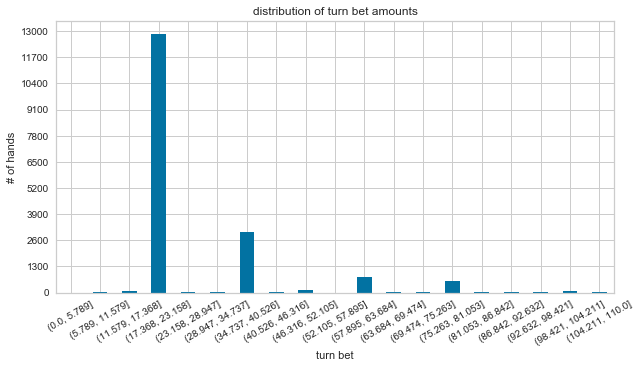

turn_bet mean is 20.63799535732051
turn_bet median is 20.0
turn_bet standard deviation is 18.493284165776046




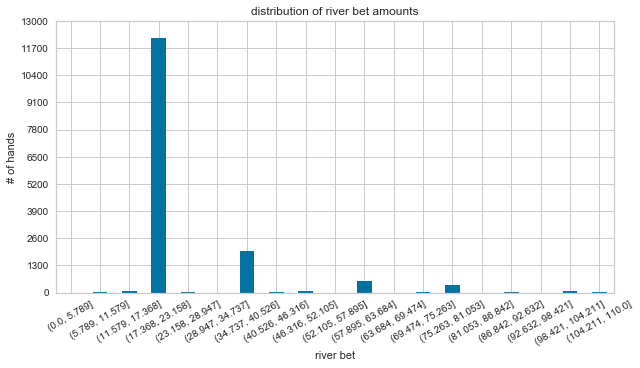

river_bet mean is 16.927995678909756
river_bet median is 20.0
river_bet standard deviation is 17.259455941613513




In [76]:
for column in ['preflop_bet', 'flop_bet', 'turn_bet', 'river_bet']:
    plot_distribution_with_bins_with_stats(hands_without_fold[hands_without_fold[column]<= 115], column, 20, 30, (10,5), 1000, 11, column[0:-4] + ' bet', '# of hands', 'distribution of ' + column[0:-4] + ' bet amounts')

###### Relationship to Hand Strength

Other than the preflop bet amount feature, there is no clear relationship between the bet amount features and average hand strength when looking at the entire range of bet amounts. 

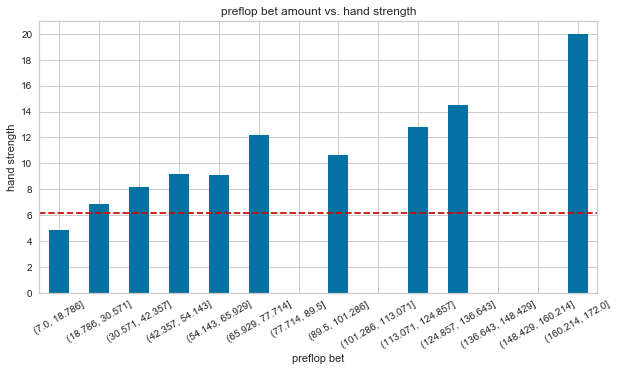

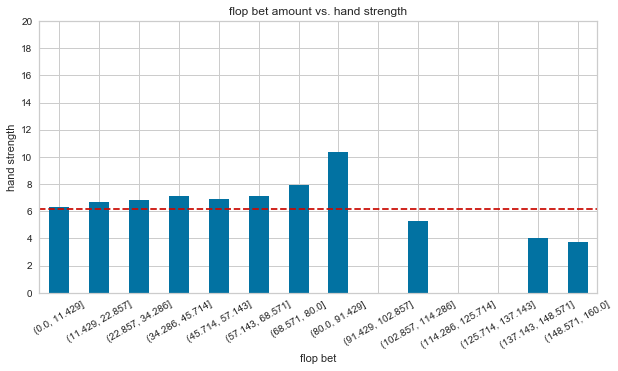

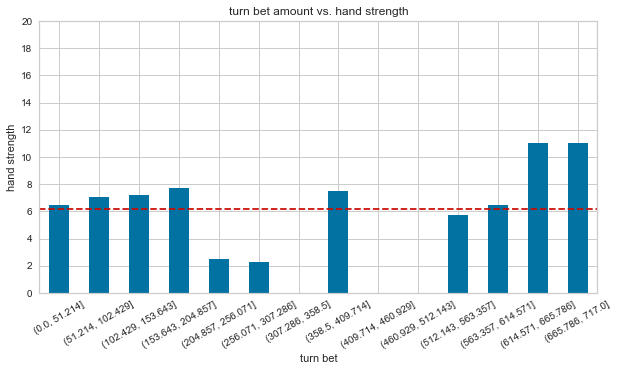

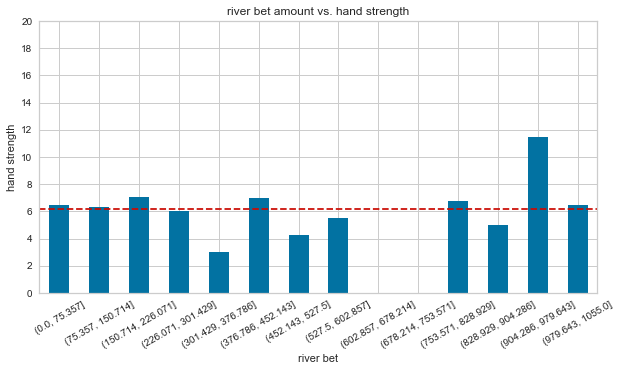

In [77]:
for column in ['preflop_bet', 'flop_bet', 'turn_bet', 'river_bet']:
    plot_feature_with_bins_with_response_var(hands_without_fold, column, 15, 'hand_strength', 'mean', 'bar', 30, (10,5), 10, 11, column[0:-4] + ' bet', 'hand strength', column[0:-4] + ' bet amount vs. hand strength')

The bet amount vs. average hand strength plots are restricted to only show bets in the range of 0-50 for the preflop and flop. In the preflop, a strong positive linear relationship between bet amount and average hand strength can be seen. There is no obvious relationship between average hand strength and flop bet amount.

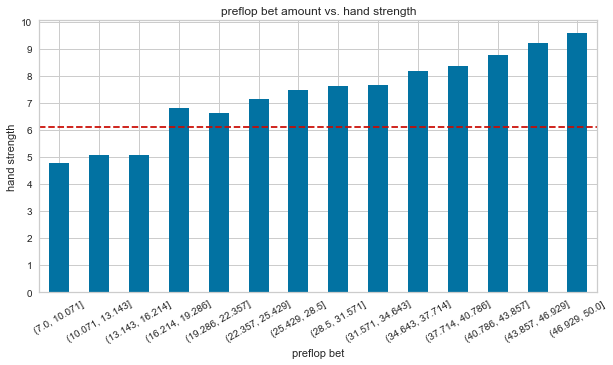

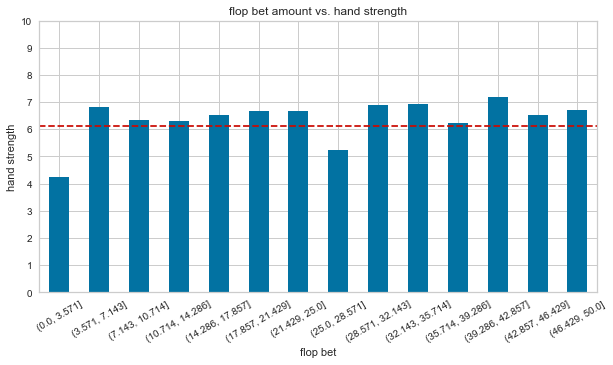

In [79]:
for column in ['preflop_bet', 'flop_bet']:
    plot_feature_with_bins_with_response_var(hands_without_fold[hands_without_fold[column]<= 50], column, 15, 'hand_strength', 'mean', 'bar', 30, (10,5), 10, 11, column[0:-4] + ' bet', 'hand strength', column[0:-4] + ' bet amount vs. hand strength')

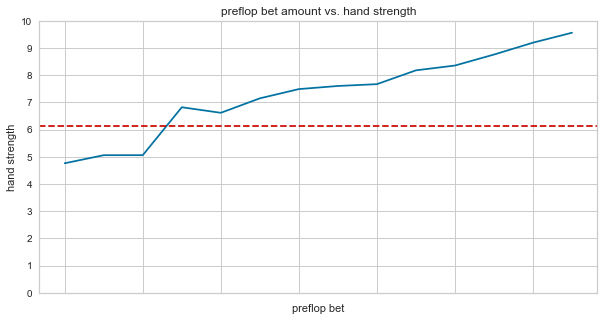

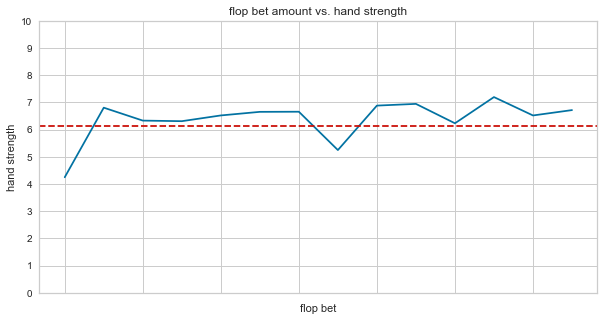

In [81]:
for column in ['preflop_bet', 'flop_bet']:
    plot_feature_with_bins_with_response_var(hands_without_fold[hands_without_fold[column]<= 50], column, 15, 'hand_strength', 'mean', 'line', 30, (10,5), 10, 11, column[0:-4] + ' bet', 'hand strength', column[0:-4] + ' bet amount vs. hand strength')

The bet amount vs. average hand strength plots are restricted to show bets in the range of 0-80 for the preflop and flop. There is no relationship between turn or river bet amount and average hand strength. 

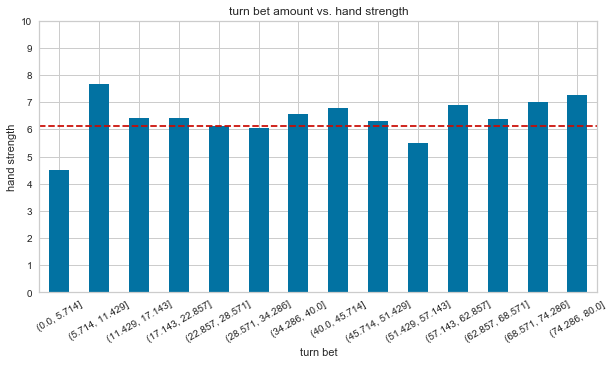

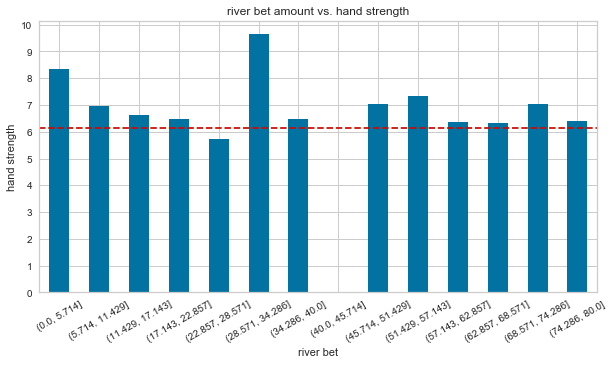

In [80]:
for column in ['turn_bet', 'river_bet']:
    plot_feature_with_bins_with_response_var(hands_without_fold[hands_without_fold[column]<= 80], column, 15, 'hand_strength', 'mean', 'bar', 30, (10,5), 10, 11, column[0:-4] + ' bet', 'hand strength', column[0:-4] + ' bet amount vs. hand strength')

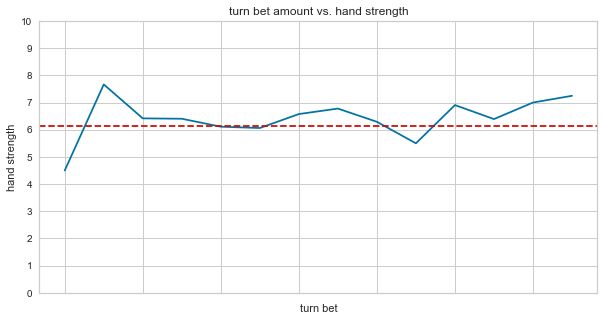

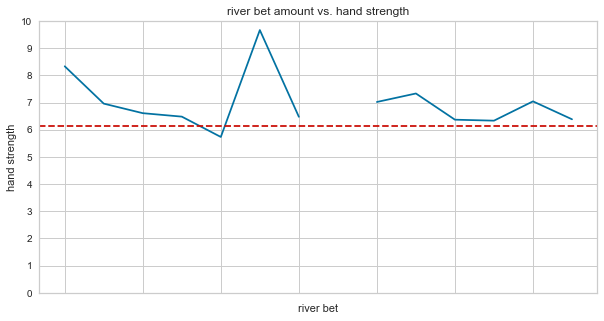

In [82]:
for column in ['turn_bet', 'river_bet']:
    plot_feature_with_bins_with_response_var(hands_without_fold[hands_without_fold[column]<= 80], column, 15, 'hand_strength', 'mean', 'line', 30, (10,5), 10, 11, column[0:-4] + ' bet', 'hand strength', column[0:-4] + ' bet amount vs. hand strength')

## Model Fitting

### Regularized Logistic Regression

The regularized logistic regression model can handle count data -- like the betting action counts and bet amounts -- as input, thus no feature conversion is required. However, a z-score standardization of the features will be performed. The betting action count features take on much smaller values compared to the betting amount features. Therefore, one would expect the model to assign larger regression coefficients to these features. Without standardization, the model will be biased towards shrinking these coefficients in order to minimize the L-2 regularization cost function.

Aside from the standardization, the model will be fit to the data as is and the 5-fold cross validation result will be used as the baseline for evaluating model performance. 



In [84]:
## Create an instance of the 'Pipeline' class,  passing inside instances of a Transformer class (e.g. 'StandardScaler') and an Estimator class (e.g. 'LogisticRegression') as arguments.
## Transformer class instances are optional depending on if the data requires some kind of transformation, but the last parameter must always be an Estimator class instance.
## The 'Pipeline' class sequentially applies the 'fit' and 'transform' methods of the Transformer class instance to a dataframe of the features and then applies the 'fit' method of the Estimator class instance to a dataframe of the features (x) and the response variable (y).
LR_hand_clf = Pipeline([('scale', StandardScaler()),('LR', LogisticRegression())])

## Create a dictionary mapping parameters of the Transformer/Estimator instances to a list of values that one would like a particular paramter to take.
parameters_LR = {'LR__C' : [1]}

## Create an instance of the 'GridSearchCV' class, passing inside the 'Pipeline' instance and the Transformer/Estimator parameters dictionary as arguments.
## The 'GridSearchCV' class instance performs an exhaustive search over the paramters values specified in the Transformer/Estimator parameters dictionary.
gs_LR_hand_clf = GridSearchCV(LR_hand_clf, parameters_LR, cv=5, n_jobs=-1, return_train_score = True)

## Mmake separate dataframes for the features (x) and the response variable (y).
x = hands_without_fold.iloc[:, list(range(16,39))]
y = hands_without_fold['hand_strength']

## Call the 'fit' method on the 'GridSearchCV' class instance, passing inside the x (features) and y (response variable) dataframes as arguments to fit the model to the data.
gs_LR_hand_clf = gs_LR_hand_clf.fit(x,y)

C:\Users\PAUL-2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [85]:
## 'cv_results_' is an attribute of the 'GridSearchCV' class instance that displays the results of the cross-validation.
gs_LR_hand_clf.cv_results_

{'mean_fit_time': array([8.05320091]),
 'std_fit_time': array([1.66914473]),
 'mean_score_time': array([0.01199923]),
 'std_score_time': array([0.0015473]),
 'param_LR__C': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'LR__C': 1}],
 'split0_test_score': array([0.19690083]),
 'split1_test_score': array([0.19855372]),
 'split2_test_score': array([0.19090909]),
 'split3_test_score': array([0.19012193]),
 'split4_test_score': array([0.18743542]),
 'mean_test_score': array([0.1927842]),
 'std_test_score': array([0.00422959]),
 'rank_test_score': array([1]),
 'split0_train_score': array([0.19531976]),
 'split1_train_score': array([0.19480318]),
 'split2_train_score': array([0.19692117]),
 'split3_train_score': array([0.19680769]),
 'split4_train_score': array([0.19742755]),
 'mean_train_score': array([0.19625587]),
 'std_train_score': array([0.0010106])}

The baseline model correctly classified 19.3% of test set cases and 19.6% of training set cases. It performed only marginally better than the null model of predicting the median hand strength for each test case would have. Perhaps it is the case that players play hands that are only different by 1 or 2 hand strength categories very similarly, making predictions of a player's precise hand strength inherently very difficult. To test this hypothesis, the percent changes in the average values of the features from one hand strength category to the next are computed. 

In [86]:
hands_without_fold.groupby(['hand_strength']).mean()

,game_id,bankroll,total_bet,preflop_check_count,preflop_call_count,preflop_raise_count,flop_x_check_count,flop_x_bet_count,flop_x_call_count,flop_x_raise_count,turn_x_check_count,turn_x_bet_count,turn_x_call_count,turn_x_raise_count,river_x_check_count,river_x_bet_count,river_x_call_count,river_x_raise_count,total check count,total bet count,total call count,total raise count,preflop_bet,flop_bet,turn_bet,river_bet
hand_strength,,,,,,,,,,,,,,,,,,,,,,,,,,
-2.0,7.982511e+08,2134.360000,58.100000,0.520000,0.500000,0.060000,0.700000,0.120000,0.300000,0.080000,0.480000,0.240000,0.420000,0.180000,0.660000,0.240000,0.240000,0.240000,2.360000,0.600000,1.460000,0.560000,13.448333,6.000000,20.400000,19.300000
-1.0,7.982811e+08,1765.679487,47.756410,0.576923,0.455128,0.057692,0.602564,0.211538,0.326923,0.089744,0.653846,0.205128,0.288462,0.121795,0.628205,0.211538,0.211538,0.108974,2.461538,0.628205,1.282051,0.378205,13.102297,7.628205,14.871795,12.820513
0.0,7.982259e+08,1589.830128,53.427885,0.483974,0.522436,0.099359,0.524038,0.256410,0.344551,0.133013,0.543269,0.282051,0.296474,0.110577,0.575321,0.264423,0.256410,0.096154,2.126603,0.802885,1.419872,0.439103,14.350389,9.243323,16.347756,14.537126
1.0,7.982167e+08,1584.003120,57.371295,0.346334,0.708268,0.081123,0.508580,0.252730,0.368175,0.151326,0.549142,0.265211,0.344774,0.110764,0.541342,0.288612,0.291732,0.118565,1.945398,0.806552,1.712949,0.461778,14.847077,9.856734,16.920177,16.823973
2.0,7.982497e+08,1681.896816,59.191627,0.295991,0.761792,0.096108,0.512382,0.261203,0.402123,0.161557,0.507665,0.291274,0.346698,0.129127,0.553066,0.288915,0.286557,0.107311,1.869104,0.841392,1.797170,0.494104,15.238706,10.628518,18.523683,16.143868
3.0,7.982412e+08,1766.556465,58.411893,0.230769,0.840698,0.084015,0.484452,0.279324,0.418985,0.147300,0.499727,0.306056,0.362793,0.109111,0.558101,0.277141,0.305510,0.091107,1.773050,0.862520,1.927987,0.431533,15.263091,10.512002,18.237225,15.580287
4.0,7.982342e+08,1785.136857,63.122699,0.172251,0.913167,0.102879,0.458707,0.284568,0.434167,0.179330,0.480415,0.303917,0.380368,0.126475,0.511090,0.308164,0.302029,0.117508,1.622463,0.896649,2.029731,0.526192,16.305351,11.591159,19.438060,17.345682
5.0,7.982096e+08,1833.928762,67.638038,0.111629,0.914115,0.206170,0.401909,0.292943,0.476698,0.174878,0.427652,0.313360,0.422326,0.138926,0.486019,0.291389,0.361074,0.121172,1.427208,0.897692,2.174212,0.641145,18.193673,11.953469,20.888593,18.204690
6.0,7.982128e+08,1878.661423,68.230164,0.091997,0.930575,0.207250,0.397059,0.294118,0.490082,0.188098,0.426813,0.318057,0.425103,0.142271,0.492476,0.288304,0.341655,0.127565,1.408345,0.900479,2.187415,0.665185,18.270501,12.462967,21.207535,17.990082


In [87]:
hands_without_fold.groupby(['hand_strength']).mean().pct_change(periods=1).describe()

,game_id,bankroll,total_bet,preflop_check_count,preflop_call_count,preflop_raise_count,flop_x_check_count,flop_x_bet_count,flop_x_call_count,flop_x_raise_count,turn_x_check_count,turn_x_bet_count,turn_x_call_count,turn_x_raise_count,river_x_check_count,river_x_bet_count,river_x_call_count,river_x_raise_count,total check count,total bet count,total call count,total raise count,preflop_bet,flop_bet,turn_bet,river_bet
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,-0.000005,-0.003181,0.036511,-0.189375,-0.003105,0.215258,-0.077404,0.098631,0.012932,0.120877,-0.041749,0.052349,0.004437,0.061256,-0.055383,0.054466,0.035503,0.002013,-0.074486,0.059704,0.005697,0.087335,0.048618,0.073872,0.034128,0.019752
std,0.000044,0.072566,0.066682,0.252811,0.195959,0.313678,0.125514,0.191364,0.074020,0.139456,0.130777,0.113039,0.117178,0.245858,0.082712,0.123144,0.118188,0.310377,0.077950,0.076160,0.093146,0.145321,0.045835,0.075204,0.108548,0.114194
min,-0.000118,-0.172736,-0.178031,-0.525760,-0.300491,-0.183534,-0.326606,-0.066732,-0.179278,-0.088248,-0.244244,-0.145299,-0.313187,-0.323362,-0.291064,-0.118590,-0.118590,-0.545940,-0.188822,-0.038639,-0.121883,-0.324634,-0.025731,-0.010963,-0.270990,-0.335725
25%,-0.000021,-0.015164,0.008754,-0.285156,-0.123564,0.005242,-0.139194,0.011268,-0.021104,0.047185,-0.109828,0.008306,-0.043450,-0.098691,-0.084184,-0.030486,-0.017739,-0.117647,-0.136068,0.018537,-0.072993,0.051641,0.004223,0.031257,0.015269,-0.011789
50%,-0.000011,0.014495,0.047121,-0.220349,-0.030519,0.123948,-0.061329,0.029429,0.028077,0.100016,-0.038645,0.036637,0.013926,0.024077,-0.049055,0.041826,0.010536,-0.008587,-0.084931,0.043195,0.006072,0.082321,0.043154,0.048900,0.035015,0.024152
75%,0.000038,0.031019,0.078807,-0.161111,0.086200,0.328409,-0.012067,0.102536,0.068563,0.175621,-0.006065,0.096679,0.048443,0.159141,-0.001174,0.091476,0.066142,0.052762,-0.039218,0.059823,0.071182,0.183455,0.089814,0.102660,0.090240,0.075668
max,0.000058,0.090528,0.118758,0.622356,0.429688,1.004006,0.237418,0.762821,0.097959,0.482143,0.362179,0.375000,0.184039,0.627869,0.089433,0.375990,0.311569,0.923622,0.105289,0.278061,0.206411,0.304161,0.117105,0.271368,0.243859,0.162473


In setting the percent change to be calculated between a hand strength category and the one previous to it, it can be seen that there is very little change in the average value of the features. The average % changes in the total bet and total check/bet/call/raise count features are about 4%, 7%, 6%, 0.6% and 9% respectively. As a result, it becomes difficult for the model to distinguish between adjacent hand strength categories. 

In [88]:
hands_without_fold.groupby(['hand_strength']).mean().pct_change(periods=3).describe()

,game_id,bankroll,total_bet,preflop_check_count,preflop_call_count,preflop_raise_count,flop_x_check_count,flop_x_bet_count,flop_x_call_count,flop_x_raise_count,turn_x_check_count,turn_x_bet_count,turn_x_call_count,turn_x_raise_count,river_x_check_count,river_x_bet_count,river_x_call_count,river_x_raise_count,total check count,total bet count,total call count,total raise count,preflop_bet,flop_bet,turn_bet,river_bet
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,-0.000020,0.013677,0.129313,-0.510375,-0.024034,0.803201,-0.223512,0.240101,0.042857,0.342660,-0.165266,0.165394,0.066519,0.192928,-0.127121,0.135679,0.132429,0.033287,-0.211551,0.169661,0.038988,0.336280,0.162202,0.193279,0.134220,0.082989
std,0.000045,0.097421,0.058553,0.202546,0.388273,0.623991,0.110256,0.255390,0.160996,0.305441,0.129892,0.112629,0.128711,0.390253,0.110731,0.187179,0.131129,0.361774,0.079195,0.103431,0.196689,0.245550,0.077502,0.150323,0.145706,0.093982
min,-0.000097,-0.257856,-0.012542,-0.831629,-0.467345,-0.154427,-0.478142,0.052964,-0.248683,0.010202,-0.416747,0.039214,-0.179110,-0.384642,-0.438128,-0.040651,-0.105237,-0.505980,-0.375721,0.044009,-0.222048,-0.175396,0.063601,0.061576,-0.170580,-0.128292
25%,-0.000045,-0.030764,0.101228,-0.607617,-0.356852,0.288151,-0.301331,0.123746,-0.084311,0.124476,-0.217086,0.084988,0.025870,0.001334,-0.146280,0.026753,0.053167,-0.057572,-0.236726,0.092992,-0.088933,0.245642,0.101114,0.106591,0.085238,0.045288
50%,-0.000036,0.025325,0.114558,-0.523179,-0.135012,0.670541,-0.208066,0.163429,0.042995,0.231464,-0.157610,0.115389,0.070153,0.075883,-0.112370,0.072313,0.149231,-0.015261,-0.205694,0.137116,-0.037342,0.314454,0.163056,0.153788,0.127670,0.071758
75%,0.000021,0.076926,0.164276,-0.492040,0.244623,1.305996,-0.140631,0.255173,0.182348,0.454305,-0.108313,0.203575,0.162113,0.247825,-0.064468,0.174484,0.205083,0.113416,-0.166126,0.249206,0.179093,0.512355,0.200536,0.194828,0.182577,0.141162
max,0.000066,0.126978,0.239449,0.048828,0.673798,1.982709,-0.075542,1.106084,0.230022,0.925385,0.144046,0.419959,0.223692,1.254426,0.009726,0.696330,0.354631,0.901591,-0.086225,0.344254,0.401792,0.793642,0.343602,0.642789,0.492965,0.259222


In setting the percent change to be calculated between hand strength categories 3 levels apart, it can be seen that there is considerable change in the average value of the features. The average % changes in the total bet and total check/bet/call/raise count features are now 13%, 21%, 17%, 4% and 34% respectively. If the hand strengths are grouped into bins that each contain 3 hand strength categories, there should be enough change in how the hands are played for the model to produce accurate yet useful predictions. 

In [89]:
## A function that takes a hand strength value (integer) as input and returns an integer specifying the bin the hand strength belongs to.
## Each key-value pair in the dictionary is a hand strength (integer) mapped to an integer corresponding to a particular hand strength bin.
def hand_strength_bin(x):
    bins = {-2:0, -1:0, 0:0, 1:1, 2:1, 3:1, 4:2, 5:2, 6:2, 7:3, 8:3, 9:3, 10:4, 11:4, 12:4, 14:5, 16:5, 20:5}
    return bins[x]

In [90]:
## Produce a 'hand strength bin' column by applying the 'hand_strength_bin' function to the 'hand strength' column.
hands_without_fold['hand_strength_bin'] = hands_without_fold['hand_strength'].apply(hand_strength_bin)

C:\Users\PAUL-2\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [91]:
LR_hand_clf = Pipeline([('scale', StandardScaler()),('LR', LogisticRegression())])
parameters_LR = {'LR__C' : [1]}
gs_LR_hand_clf = GridSearchCV(LR_hand_clf, parameters_LR, cv=5, n_jobs=-1, return_train_score = True)
x = hands_without_fold.iloc[:, list(range(16,39))]
y = hands_without_fold['hand_strength_bin']
gs_LR_hand_clf = gs_LR_hand_clf.fit(x,y)

C:\Users\PAUL-2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [92]:
gs_LR_hand_clf.cv_results_

{'mean_fit_time': array([3.87939854]),
 'std_fit_time': array([0.71052541]),
 'mean_score_time': array([0.00980096]),
 'std_score_time': array([0.00231599]),
 'param_LR__C': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'LR__C': 1}],
 'split0_test_score': array([0.42644628]),
 'split1_test_score': array([0.42169421]),
 'split2_test_score': array([0.41694215]),
 'split3_test_score': array([0.41351519]),
 'split4_test_score': array([0.4139285]),
 'mean_test_score': array([0.41850527]),
 'std_test_score': array([0.00492991]),
 'rank_test_score': array([1]),
 'split0_train_score': array([0.41910321]),
 'split1_train_score': array([0.41884492]),
 'split2_train_score': array([0.42106623]),
 'split3_train_score': array([0.42130275]),
 'split4_train_score': array([0.42145772]),
 'mean_train_score': array([0.42035497]),
 'std_train_score': array([0.00113731])}

After grouping the hand strength categories into 6 bins, the model accuracy has increased considerably from 19.3% to 41.9%. The similarity between the training set scores and test set scores indicates that the model is underfitting, not overfitting the data. Hence, the strategies to improve model performance are to increase the complexity of the model and/or to add more informative features.

Firstly, it's possible that the relationships between the log odds of a hand falling in a particular hand strength category and the features are not linear. To test this hypothesis, degree 2 polynomial features will be introduced into the model (e.g. add a (total bet amount^2) feature) to see if prediction accuracy increases. 

Secondly, it's possible that some interaction terms are missing from the model. In particular, there could be an interaction between bank roll, a feature not yet introduced into the model, and each of the predictors. For example, the total raise count feature may have a stronger relationship with the log odds of the response when bankroll is lower versus when it is higher. To test this hypothesis, the bankroll feature will be introduced into the model and interaction terms between each of the features and all the other features will be produced to see if prediction accuracy improves.

Note: little to no colinearity between the independent variables is also an assumption of linear models. However, the primary objective with this analysis is prediction instead of inference. Therefore, handling colinearity in the data set for the logistic regression fit is not a concern. 

In [93]:
## 'polynomial' is an instance of the 'PolynomialFeatures' class.
## Inside the pipeline, the 'fit' and 'transform' methods of the 'PolynomialFeatures' class instance will be called to produce new columns for the features dataframe that include polynomial features and interaction terms.
LR_hand_clf = Pipeline([('polynomial', PolynomialFeatures()), ('scale', StandardScaler()), ('LR', LogisticRegression())])
parameters_LR = {'LR__C' : [1], 'polynomial__degree': [2]}
gs_LR_hand_clf = GridSearchCV(LR_hand_clf, parameters_LR, cv=5, n_jobs=-1, return_train_score = True)
x = hands_without_fold.iloc[:, [6] + list(range(16,39))]
y = hands_without_fold['hand_strength_bin']
gs_LR_hand_clf = gs_LR_hand_clf.fit(x,y)

C:\Users\PAUL-2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [94]:
gs_LR_hand_clf.cv_results_

{'mean_fit_time': array([13.14241934]),
 'std_fit_time': array([2.77767149]),
 'mean_score_time': array([0.09460082]),
 'std_score_time': array([0.01971532]),
 'param_LR__C': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_polynomial__degree': masked_array(data=[2],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'LR__C': 1, 'polynomial__degree': 2}],
 'split0_test_score': array([0.41838843]),
 'split1_test_score': array([0.42190083]),
 'split2_test_score': array([0.41280992]),
 'split3_test_score': array([0.40876214]),
 'split4_test_score': array([0.40524902]),
 'mean_test_score': array([0.41342207]),
 'std_test_score': array([0.00609003]),
 'rank_test_score': array([1]),
 'split0_train_score': array([0.43217275]),
 'split1_train_score': array([0.43212109]),
 'split2_train_score': array([0.43325757]),
 'split3_train_score': array([0.43349347]),
 'split4_train_score': array([0.43

Including the interaction terms and polynomial features into the model made virtually no difference to the prediction accuracy. As such, the simpler model without the additional features is the better model for the data as it runs a lower risk of having overfit the training and test data. At this point, the only model improvement to be made is fine-tuning the regularization constant hyperparameter. With such similar training and test set prediction accuracies, the data is still being underfit so it is possible that the chosen regularization constant (1) is too large.

In [95]:
LR_hand_clf = Pipeline([('scale', StandardScaler()),('LR', LogisticRegression())])
parameters_LR = {'LR__C' : [1, 2, 5, 10]}
gs_LR_hand_clf = GridSearchCV(LR_hand_clf, parameters_LR, cv=5, n_jobs=-1, return_train_score = True)
x = hands_without_fold.iloc[:, list(range(16,39))]
y = hands_without_fold['hand_strength_bin']
gs_LR_hand_clf = gs_LR_hand_clf.fit(x,y)

C:\Users\PAUL-2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [96]:
gs_LR_hand_clf.cv_results_

{'mean_fit_time': array([3.54260101, 3.35180178, 3.54241939, 3.27701859]),
 'std_fit_time': array([0.09935725, 0.2673044 , 0.25488461, 0.1619535 ]),
 'mean_score_time': array([0.0099999 , 0.01039939, 0.00900092, 0.0088006 ]),
 'std_score_time': array([0.00109707, 0.00149664, 0.00063241, 0.00231649]),
 'param_LR__C': masked_array(data=[1, 2, 5, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'LR__C': 1}, {'LR__C': 2}, {'LR__C': 5}, {'LR__C': 10}],
 'split0_test_score': array([0.42644628, 0.42603306, 0.42623967, 0.42603306]),
 'split1_test_score': array([0.42169421, 0.42169421, 0.42169421, 0.4214876 ]),
 'split2_test_score': array([0.41694215, 0.41694215, 0.41673554, 0.41673554]),
 'split3_test_score': array([0.41351519, 0.41330853, 0.41351519, 0.41372184]),
 'split4_test_score': array([0.4139285 , 0.41372184, 0.41351519, 0.41351519]),
 'mean_test_score': array([0.41850527, 0.41833996, 0.41833996, 0.41829865]),
 'std_

The training and test set prediction accuracies are virtually identical across the entire hyperparameter space. Therefore, the choice of regularization constant was not the cause for underfitting.

#### Best Logistic Regression Model Prediction Accuracy: ~ 42%.

### Multinomial Naive Bayes

On one hand, it is unlikely that a Multinomial Naive Bayes model will yield a prediction accuracy greater than 42% when the more complex model, Logistic Regression, was still underfitting the data. However, there is a motivation for fitting this model to the data; Naive Bayes is more robust to high leverage points as compared to Logistic Regression because the Naive Bayes model parameters are not derived from a Maximum Likelihood Estimation. As such, it is possible that the Naive Bayes model produces more accurate predictions given that there are a number of high leverage points in the data set. 

The Multinomial Naive Bayes model requires non-continuous variables as input, thus the bet amount features will be binned into intervals. There are a few binning strategies to choose from: uniform, quantile and k-means. The bet amount features have a large overall range, but most bet amounts are concentrated within a small range of values so the uniform and k-means binning strategies would end up producing a few bins with the majority of data points and many bins with hardly any data points at all. Concentrating most of the bet amounts into a single bin would render them useless in distinguishing between different hand strength categories. Therefore, the quantile binning strategy which produces bins with an equal number of data points in each will be used.  

A 5-fold cross validation will be performed to get an estimate of the prediction accuracy on a test set. 


In [101]:
## Create an instance of the 'KBinsDiscretizer' class and call the 'fit' and 'transform' methods on the class instance, passing a dataframe of the bet amount features as an argument.
discrete_bet_amount_features = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='quantile').fit_transform(hands_without_fold[['total_bet', 'preflop_bet', 'flop_bet', 'turn_bet', 'river_bet']])

C:\Users\PAUL-2\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\PAUL-2\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\PAUL-2\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\PAUL-2\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  'decreasing

In [105]:
## The object produced by calling the 'fit' and 'transform' methods is an array of all the bet amounts mapped onto an integer corresponding to a particular bin. 
discrete_bet_amount_features

array([[5., 2., 1., 2., 1.],
       [5., 2., 1., 2., 1.],
       [4., 3., 2., 1., 1.],
       ...,
       [4., 4., 1., 1., 1.],
       [5., 4., 2., 1., 1.],
       [5., 4., 2., 1., 1.]])

In [103]:
## Convert the array produced from the last step into a dataframe.
discrete_bet_amount_features_df = pd.DataFrame(discrete_bet_amount_features, columns = ['total_bet_bin', 'preflop_bet_bin', 'flop_bet_bin', 'turn_bet_bin', 'river_bet_bin'])

In [104]:
discrete_bet_amount_features_df

,total_bet_bin,preflop_bet_bin,flop_bet_bin,turn_bet_bin,river_bet_bin
0,5.0,2.0,1.0,2.0,1.0
1,5.0,2.0,1.0,2.0,1.0
2,4.0,3.0,2.0,1.0,1.0
3,4.0,3.0,2.0,1.0,1.0
4,3.0,2.0,1.0,1.0,1.0
...,...,...,...,...,...
24193,5.0,4.0,2.0,2.0,1.0
24194,4.0,4.0,1.0,1.0,1.0
24195,4.0,4.0,1.0,1.0,1.0
24196,5.0,4.0,2.0,1.0,1.0


In [106]:
## Concatenate the 'hands_without fold' dataframe with the columns for the binned bet amounts. 
hands_without_fold_naive_bayes = pd.concat([hands_without_fold.reset_index(), discrete_bet_amount_features_df], axis=1)

In [107]:
hands_without_fold_naive_bayes

,index,player_name,game_id,preflop,flop_x,turn_x,river_x,bankroll,total_bet,card_1,card_2,flop_y,turn_y,river_y,showdown,pocket,hand_strength,preflop_check_count,preflop_call_count,preflop_raise_count,flop_x_check_count,flop_x_bet_count,flop_x_call_count,flop_x_raise_count,turn_x_check_count,turn_x_bet_count,turn_x_call_count,turn_x_raise_count,river_x_check_count,river_x_bet_count,river_x_call_count,river_x_raise_count,total check count,total bet count,total call count,total raise count,preflop_bet,flop_bet,turn_bet,river_bet,hand_strength_bin,total_bet_bin,preflop_bet_bin,flop_bet_bin,turn_bet_bin,river_bet_bin
0,1,an_idiot,798243437,r,b,br,b,830,110,Ts,Qs,4/85,2/105,2/225,2/265,Ts Qs,8.0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,3,0,2,21.25,10.0,60.0,20.0,3,5.0,2.0,1.0,2.0,1.0
1,6,Jime,798243437,c,c,rc,c,2374,110,As,Jd,4/85,2/105,2/225,2/265,As Jd,8.0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,4,1,21.25,10.0,60.0,20.0,3,5.0,2.0,1.0,2.0,1.0
2,26,derek,798243633,r,br,b,b,2970,90,Qh,Qd,3/75,2/145,2/185,2/225,Qh Qd,14.0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,3,0,2,25.00,35.0,20.0,20.0,5,4.0,3.0,2.0,1.0,1.0
3,31,Schween,798243633,c,rc,c,c,3050,90,8s,Ks,3/75,2/145,2/185,2/225,8s Ks,5.0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,4,1,25.00,35.0,20.0,20.0,2,4.0,3.0,2.0,1.0,1.0
4,36,bharat,798243712,Br,b,b,b,800,70,Js,Ts,3/60,2/80,2/120,2/160,Js Ts,9.0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,3,0,1,20.00,10.0,20.0,20.0,3,3.0,2.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24193,139720,][,797322985,Br,r,rc,c,1145,130,6s,6d,2/60,2/100,2/220,2/260,6s 6d,6.0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,2,3,30.00,20.0,60.0,20.0,2,5.0,4.0,2.0,2.0,1.0
24194,139744,_-_-_-_-,797323495,Brc,kc,kc,kc,1000,90,7c,Ad,2/85,2/105,2/145,2/185,7c Ad,5.0,0,1,1,1,0,1,0,1,0,1,0,1,0,1,0,3,0,4,1,42.50,10.0,20.0,20.0,2,4.0,4.0,1.0,1.0,1.0
24195,139745,_O_,797323495,rr,b,b,b,985,90,Tc,Qs,2/85,2/105,2/145,2/185,Tc Qs,6.0,0,0,2,0,1,0,0,0,1,0,0,0,1,0,0,0,3,0,2,42.50,10.0,20.0,20.0,2,4.0,4.0,1.0,1.0,1.0
24196,139747,|-|-|-|,797323574,Bcc,rc,kc,kc,985,110,7c,9c,4/160,3/250,3/310,2/350,7c 9c,6.0,0,2,0,0,0,1,1,1,0,1,0,1,0,1,0,2,0,5,1,40.00,30.0,20.0,20.0,2,5.0,4.0,2.0,1.0,1.0


In [108]:
MNB_hand_clf = Pipeline([('MNB_hand_clf', MultinomialNB())])
parameters_MNB = {'MNB_hand_clf__fit_prior' : [True]}
gs_MNB_hand_clf = GridSearchCV(MNB_hand_clf, parameters_MNB, cv=5, n_jobs=-1, return_train_score = True)
x = hands_without_fold_naive_bayes.iloc[:, list(range(17,36)) + list(range(41,46))]
y = hands_without_fold_naive_bayes['hand_strength_bin']
gs_MNB_hand_clf = gs_MNB_hand_clf.fit(x,y)

In [109]:
gs_MNB_hand_clf.cv_results_

{'mean_fit_time': array([0.0355998]),
 'std_fit_time': array([0.00233056]),
 'mean_score_time': array([0.00499897]),
 'std_score_time': array([0.00089442]),
 'param_MNB_hand_clf__fit_prior': masked_array(data=[True],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'MNB_hand_clf__fit_prior': True}],
 'split0_test_score': array([0.37045455]),
 'split1_test_score': array([0.35971074]),
 'split2_test_score': array([0.36177686]),
 'split3_test_score': array([0.36433147]),
 'split4_test_score': array([0.33415995]),
 'mean_test_score': array([0.35808671]),
 'std_test_score': array([0.01249564]),
 'rank_test_score': array([1]),
 'split0_train_score': array([0.35788821]),
 'split1_train_score': array([0.35897303]),
 'split2_train_score': array([0.35990288]),
 'split3_train_score': array([0.36267369]),
 'split4_train_score': array([0.36375846]),
 'mean_train_score': array([0.36063926]),
 'std_train_score': array([0.00222509])}

In [110]:
## Call the "corr' method on the dataframe of features.
corr = hands_without_fold_naive_bayes.iloc[:, list(range(17,36)) + list(range(41,46))].corr(method='spearman')

## Produce a correlation heatmap.
corr.style.background_gradient(cmap='coolwarm')

,preflop_check_count,preflop_call_count,preflop_raise_count,flop_x_check_count,flop_x_bet_count,flop_x_call_count,flop_x_raise_count,turn_x_check_count,turn_x_bet_count,turn_x_call_count,turn_x_raise_count,river_x_check_count,river_x_bet_count,river_x_call_count,river_x_raise_count,total check count,total bet count,total call count,total raise count,total_bet_bin,preflop_bet_bin,flop_bet_bin,turn_bet_bin,river_bet_bin
preflop_check_count,1.000000,-0.486212,-0.239557,0.151354,-0.053169,-0.107198,-0.077162,0.117937,-0.044234,-0.081090,-0.053362,0.089557,-0.043841,-0.053824,-0.024847,0.381492,-0.064946,-0.309290,-0.212861,-0.230759,-0.393369,-0.174428,-0.132578,-0.097011
preflop_call_count,-0.486212,1.000000,-0.542092,0.055839,-0.185302,0.238004,-0.006062,0.024216,-0.109672,0.140993,0.023536,-0.002465,-0.038015,0.063583,0.026362,-0.081504,-0.148476,0.617997,-0.294805,0.072645,0.054543,0.067680,0.054023,0.030133
preflop_raise_count,-0.239557,-0.542092,1.000000,-0.219496,0.240400,-0.093596,0.126883,-0.144897,0.150784,-0.031642,0.063109,-0.096529,0.081965,0.011452,0.007902,-0.246604,0.213293,-0.287622,0.660839,0.282297,0.605471,0.156279,0.112991,0.089247
flop_x_check_count,0.151354,0.055839,-0.219496,1.000000,-0.546106,-0.137881,-0.274158,0.432981,-0.221631,-0.071212,-0.088292,0.271769,-0.099753,-0.099628,-0.059783,0.719874,-0.395188,-0.085975,-0.316708,-0.399156,-0.185451,-0.638838,-0.268074,-0.213584
flop_x_bet_count,-0.053169,-0.185302,0.240400,-0.546106,1.000000,-0.226940,-0.091866,-0.135471,0.381650,-0.110035,-0.043947,-0.030244,0.160490,-0.000803,-0.028554,-0.284960,0.699537,-0.208862,0.090258,0.166373,0.101370,0.282103,0.113965,0.096374
flop_x_call_count,-0.107198,0.238004,-0.093596,-0.137881,-0.226940,1.000000,-0.137370,0.076502,-0.331675,0.414992,0.090731,-0.026547,-0.086332,0.181128,0.069415,-0.058759,-0.284230,0.696975,-0.053133,0.264713,0.129674,0.419124,0.171097,0.119703
flop_x_raise_count,-0.077162,-0.006062,0.126883,-0.274158,-0.091866,-0.137370,1.000000,-0.214426,0.162920,-0.031822,0.105012,-0.164450,0.096570,0.029989,0.043648,-0.286628,0.087696,-0.053947,0.550458,0.360947,0.131841,0.600708,0.152266,0.129611
turn_x_check_count,0.117937,0.024216,-0.144897,0.432981,-0.135471,0.076502,-0.214426,1.000000,-0.601747,-0.114652,-0.181200,0.396056,-0.207655,-0.071074,-0.081497,0.770639,-0.417835,-0.026650,-0.283101,-0.472932,-0.130834,-0.203180,-0.626928,-0.280696
turn_x_bet_count,-0.044234,-0.109672,0.150784,-0.221631,0.381650,-0.331675,0.162920,-0.601747,1.000000,-0.282867,-0.090926,-0.152608,0.331440,-0.084618,-0.026679,-0.397742,0.773741,-0.302682,0.137192,0.255124,0.074637,0.131749,0.340328,0.155903
turn_x_call_count,-0.081090,0.140993,-0.031642,-0.071212,-0.110035,0.414992,-0.031822,-0.114652,-0.282867,1.000000,-0.107057,0.041099,-0.277744,0.376361,0.086365,-0.074783,-0.300530,0.704259,-0.043470,0.327473,0.098493,0.180896,0.427304,0.155753


From the correlation matrix, it can be seen that the following pairs of features have a correlation >= 0.7: flop/turn/river check count and total check count, flop/turn/river bet count and total bet count, flop/turn call count and total call count, turn bet bin and total bet bin, river check count and river bet bin. To mitigate the feature correlation in the dataset, the flop/turn/river check count, flop/turn/river bet count, flop/turn call count and turn bet bin features will be dropped. 

While the intention is to deflate the importance of correlated features in the model, it is possible that in dropping these features, some important variance in the dataset will be lost and the model will underfit the data further. Another 5-fold cross validation is performed to see if prediction accuracy increases or decreases after dropping the correlated features. 

In [111]:
## Dropping the correlated features from the dataframe.
hands_without_fold_nb_independent_features = hands_without_fold_naive_bayes.drop(['flop_x_check_count', 'turn_x_check_count', 'river_x_check_count', 'flop_x_bet_count', 'turn_x_bet_count', 'river_x_bet_count', 'flop_x_call_count', 'turn_x_call_count', 'turn_bet_bin'],  axis = 1)

In [112]:
MNB_hand_clf = Pipeline([('MNB_hand_clf', MultinomialNB())])
parameters_MNB = {'MNB_hand_clf__fit_prior' : [True]}
gs_MNB_hand_clf = GridSearchCV(MNB_hand_clf, parameters_MNB, cv=5, n_jobs=-1, return_train_score = True)
x = hands_without_fold_nb_independent_features.iloc[:, list(range(17,32)) + [33,34,35,36]]
y = hands_without_fold_nb_independent_features['hand_strength_bin']
gs_MNB_hand_clf = gs_MNB_hand_clf.fit(x,y)

In [113]:
gs_MNB_hand_clf.cv_results_

{'mean_fit_time': array([0.04179773]),
 'std_fit_time': array([0.0088191]),
 'mean_score_time': array([0.00439949]),
 'std_score_time': array([0.00049002]),
 'param_MNB_hand_clf__fit_prior': masked_array(data=[True],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'MNB_hand_clf__fit_prior': True}],
 'split0_test_score': array([0.37107438]),
 'split1_test_score': array([0.3607438]),
 'split2_test_score': array([0.3768595]),
 'split3_test_score': array([0.34531928]),
 'split4_test_score': array([0.34035958]),
 'mean_test_score': array([0.35887131]),
 'std_test_score': array([0.01415866]),
 'rank_test_score': array([1]),
 'split0_train_score': array([0.35912801]),
 'split1_train_score': array([0.3534456]),
 'split2_train_score': array([0.36475876]),
 'split3_train_score': array([0.35549357]),
 'split4_train_score': array([0.37037037]),
 'mean_train_score': array([0.36063926]),
 'std_train_score': array([0.0061996])}

Dropping the correlated features had virtually no effect on the mean test set prediction accuracy. 

#### Best Multinomial Naive Bayes Model Prediction Accuracy: ~ 36%

### AdaBoost (Boosted) Decision Tree

Similar to the situation with the Naive Bayes model, the AdaBoost (Boosted) Decision Tree model faces the challenge of yielding a prediction accuracy greater than 40% when the more complex model, Logistic Regression, was still underfitting the data. However, there are two motivations for fitting this model to the data: 1) AdaBoost (Boosted) Decision Trees are more robust to high leverage points as compared to Logistic Regression because the AdaBoost (Boosted) Decision Tree model does not rely on a Maximum Likelihood Estimation and 2) AdaBoost (Boosted) Decision Tree models do not require the dataset to meet a feature independence assumption.

The AdaBoost (Boosted) Decision Tree model can handle both continous and non-continous features as input, therefore no feature conversion is needed. 

A 5-fold cross validation will be performed to get an estimate of prediction accuracy on a test set. 

In [114]:
ada_hand_clf = Pipeline([('ada', AdaBoostClassifier())])
parameters_ada = {'ada__n_estimators' : [100]}
gs_ada_hand_clf = GridSearchCV(ada_hand_clf, parameters_ada, cv=5, n_jobs=-1, return_train_score = True)
x = hands_without_fold.iloc[:, list(range(16,39))]
y = hands_without_fold['hand_strength_bin']
gs_ada_hand_clf = gs_ada_hand_clf.fit(x,y)

In [115]:
gs_ada_hand_clf.cv_results_

{'mean_fit_time': array([3.64259982]),
 'std_fit_time': array([0.42951451]),
 'mean_score_time': array([0.26439986]),
 'std_score_time': array([0.04496452]),
 'param_ada__n_estimators': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'ada__n_estimators': 100}],
 'split0_test_score': array([0.41487603]),
 'split1_test_score': array([0.42561983]),
 'split2_test_score': array([0.41363636]),
 'split3_test_score': array([0.41578839]),
 'split4_test_score': array([0.40400909]),
 'mean_test_score': array([0.41478594]),
 'std_test_score': array([0.00686802]),
 'rank_test_score': array([1]),
 'split0_train_score': array([0.41750181]),
 'split1_train_score': array([0.41641699]),
 'split2_train_score': array([0.42168612]),
 'split3_train_score': array([0.41882329]),
 'split4_train_score': array([0.4175319]),
 'mean_train_score': array([0.41839202]),
 'std_train_score': array([0.00181495])}

The AdaBoost (Boosted) Decision Tree model performed just as well as the Logistic Regression model. It seems like the robustness to high leverage points and removal of the feature independance assumption allowed it to reach a similar prediction accuracy. Though both models had the same prediction accuracy, the decision tree model is the better model because it is simpler and thus less likely to have overfit the training and test data. 

#### Best AdaBoost (Boosted) Decision Tree Model Prediction Accuracy: ~ 41.5%

## Clustering

Thus far, only a single model to fit all the player data and predict hand strength has been generated. An obvious limitation with this strategy is that it does not account for the possibility that the relationships between betting actions and amounts and hand strength likely vary from player to player. The model that best predicts a particular player type's hand strength might be very different from the single model that best fits all the player types.

There are two main dimensions that characterize a player's play style: loose/tight and passive/aggressive. A player's looseness or tightness is defined by the proportion of hands the player flops on in the preflop. A player's passiveness or aggressiveness is defined by the ratio of how many times that player has betted or raised to how many times they have called. 

Each player in the data set will be scored on each of these two dimensions and then a k-means clustering will be performed to group together players who have scored similarily to one another. Then, seperate AdaBoost (Boosted) Decision Tree model will be fit to each of these different player groups to see how the prediction accuracies for each of the groups compare to the accuracy of the single AdaBoost (Boosted) Decision Tree model fit to the whole dataset. 



In [117]:
## A function which takes a string encoding betting actions as input, and returns 1 if the characters "f" or "Q" are in the string, and 0 otherwise.
def if_fold_or_quit(preflop):
    if "f" in preflop or "Q" in preflop:
        return 1
    else:
        return 0

In [118]:
## An 'if fold' column is created in the 'all_hands' dataframe by applying the 'if_fold_or_quit' function to the 'preflop' column.
all_hands['if_fold'] = all_hands['preflop'].apply(if_fold_or_quit)

In [119]:
all_hands['if_fold']

0         1
1         0
2         0
3         1
4         1
         ..
139751    0
139752    1
139753    1
139754    1
139755    0
Name: if_fold, Length: 139756, dtype: int64

Only those players who have played at least 50 hands will be included into the clustering. This requirement is justified  because otherwise the sample size from which one would calculate a player's loose/tight and passive/aggressive scores would be too small to be representative of a player's style of play.  

In [120]:
## Group the 'all_hands' dataframe by player name.
## Groups (players) with less than 50 played hands (rows) are filtered out.
## Apply different aggregation methods on the different columns of the groupby object.
player_scores = all_hands.groupby(['player_name']).filter(lambda x: len(x) >= 50).groupby(['player_name']).agg(total_bet_count=pd.NamedAgg(column='total bet count', aggfunc=np.sum), total_call_count=pd.NamedAgg(column='total call count', aggfunc=np.sum), total_raise_count=pd.NamedAgg(column='total raise count', aggfunc=np.sum), total_fold_count=pd.NamedAgg(column='if_fold', aggfunc=np.sum), total_hand_count=pd.NamedAgg(column='if_fold', aggfunc='count')).reset_index()

In [121]:
player_scores

,player_name,total_bet_count,total_call_count,total_raise_count,total_fold_count,total_hand_count
0,ACC,12,17,8,46,61
1,ACESUP,347,1049,199,765,1438
2,Arby,59,496,25,338,632
3,Beatle,175,517,63,175,464
4,BeesiTzu,226,472,128,302,589
...,...,...,...,...,...,...
283,will,11,73,10,76,129
284,ws16,49,151,22,26,101
285,wsk,1224,2164,922,598,2383
286,x^2-y^2,22,60,22,44,82


In [122]:
player_scores['passive/aggressive'] = (player_scores['total_bet_count'] + player_scores['total_raise_count'])/player_scores['total_call_count']
player_scores['loose/tight'] = player_scores['total_fold_count']/player_scores['total_hand_count']

In [123]:
player_scores

,player_name,total_bet_count,total_call_count,total_raise_count,total_fold_count,total_hand_count,passive/aggressive,loose/tight
0,ACC,12,17,8,46,61,1.176471,0.754098
1,ACESUP,347,1049,199,765,1438,0.520496,0.531989
2,Arby,59,496,25,338,632,0.169355,0.534810
3,Beatle,175,517,63,175,464,0.460348,0.377155
4,BeesiTzu,226,472,128,302,589,0.750000,0.512733
...,...,...,...,...,...,...,...,...
283,will,11,73,10,76,129,0.287671,0.589147
284,ws16,49,151,22,26,101,0.470199,0.257426
285,wsk,1224,2164,922,598,2383,0.991682,0.250944
286,x^2-y^2,22,60,22,44,82,0.733333,0.536585


In [124]:
player_scores.describe()

,total_bet_count,total_call_count,total_raise_count,total_fold_count,total_hand_count,passive/aggressive,loose/tight
count,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,139.989583,336.336806,103.076389,225.423611,470.677083,0.926420,0.465830
std,192.745151,411.715280,147.652364,334.628851,631.186486,1.993629,0.168954
min,2.000000,10.000000,3.000000,0.000000,51.000000,0.169355,0.000000
25%,33.750000,84.750000,20.000000,48.750000,116.500000,0.446749,0.358100
50%,69.500000,166.000000,50.000000,105.500000,218.000000,0.653364,0.500000
75%,165.250000,412.500000,120.000000,263.000000,573.250000,0.992896,0.591290
max,1224.000000,2508.000000,922.000000,2331.000000,4144.000000,31.500000,0.825000


The range and spread of the passive/aggressive scores are much higher than the range and spread of the loose/tight scores because the loose/tight scores are necessarily restricted to values between 0 and 1. If k-means clustering was performed on the data as is, the clustering would be much more influenced by the scores on the passive/aggressive dimension than the scores on the loose/tight dimension. Thus, the data on these two dimensions will be standardized so that both dimensions have equal influence on the results of the clustering.

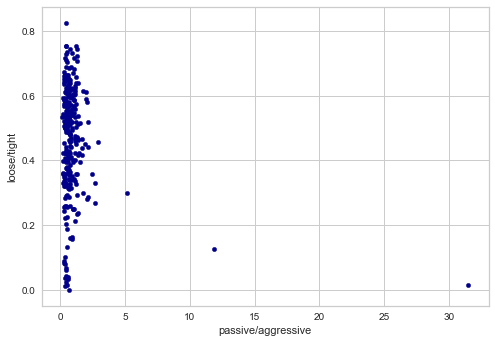

In [125]:
ax1 = player_scores.plot.scatter(x='passive/aggressive', y='loose/tight', c='DarkBlue')

In producing a scatter plot of the player scores on the two dimensions, it can be seen that there are a couple of outlier points where the passive/aggressive scores are around 5, 12  and 32. These points will be removed from the dataset because their inclusion would unduly influence the results of the clustering. These points have passive/aggressive scores that are so far away from the normal range of values along this dimension that the k-means algorithm would produce cluster centers close to these points, causing the bulk of the data to be assigned to a single cluster.

In [126]:
## Removing outlier points from the 'player_scores' dataframe.
player_scores_no_outlier = player_scores[player_scores['passive/aggressive'] <= 5]

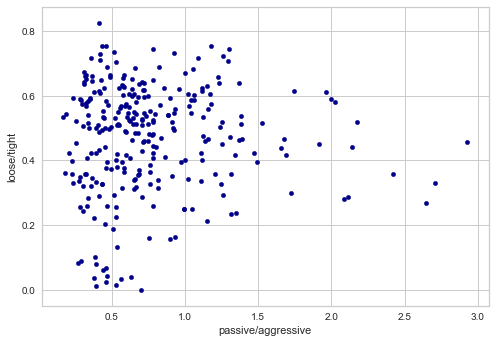

In [127]:
ax2 = player_scores_no_outlier.plot.scatter(x='passive/aggressive', y='loose/tight', c='DarkBlue')

Looking at the same scatter plot without the outlier points, it can be seen that there aren't any distinct clusters, which makes the job of finding the optimal number of clusters difficult. In order to tackle this problem, the elbow method will be implemented, whereby the intra-cluster variation will be plotted against the number of clusters (K) to look for the point after which the intra-cluster variation seems to level off with additional clusters.

In [129]:
## Create an instance of the 'StandardScaler' class and call the 'fit' and 'transform' methods of the class on it, passing the dataframe of player scores as an argument.
X = player_scores_no_outlier[['loose/tight', 'passive/aggressive']]
X_std = StandardScaler().fit_transform(X)

In [130]:
## The output is an array of the standardized player scores. 
X_std

array([[ 1.71746093e+00,  8.90446715e-01],
       [ 3.78586396e-01, -5.31875250e-01],
       [ 3.95592891e-01, -1.29323882e+00],
       [-5.54750142e-01, -6.62290576e-01],
       [ 2.62514808e-01, -3.42510215e-02],
       [ 1.65254297e-01, -6.14221798e-01],
       [ 4.86833611e-01, -4.88148145e-01],
       [-4.54383223e-01, -6.51732838e-01],
       [-2.42290846e+00, -6.57624840e-01],
       [-2.33181606e+00, -1.07738295e+00],
       [ 3.70418209e-03,  1.54841138e-01],
       [-1.09228629e+00, -1.32913669e-01],
       [-1.73709824e-01, -6.76388601e-01],
       [ 2.35990955e-01, -7.71458320e-01],
       [-2.59932791e+00, -8.38490049e-01],
       [ 9.34615180e-01, -6.89383816e-01],
       [ 1.12245561e-01, -7.63233898e-01],
       [ 1.20236008e-01, -3.60925467e-01],
       [-3.48928750e-01,  2.14083805e-01],
       [ 2.93400416e-01,  3.42858301e-02],
       [-1.27262784e+00, -9.37691338e-01],
       [ 4.44469842e-01, -2.08344630e-01],
       [-2.62730594e+00, -4.33128444e-01],
       [ 6.

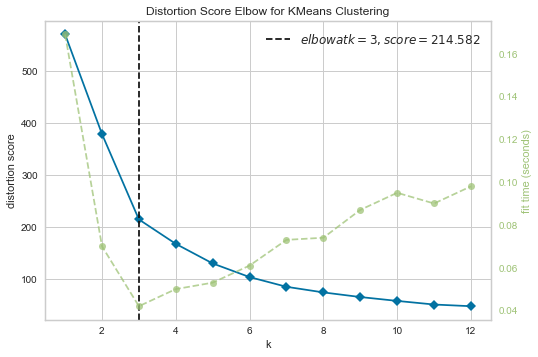

In [131]:
## Create an instance of the 'KMeans' class.
kmeans = KMeans()

## Create an instance of the 'KElbowVisualizer' class, passing the 'KMeans' class instance and a range of values for K (# of clusters) as arguments.
kmeans_visualizer = KElbowVisualizer(kmeans, k=(1,13))

## Call the 'fit' method on the 'KElbowVisualizer' class instance, which performs a K-means clustering of the standardized player scores for each value of K specified in the line above.
kmeans_visualizer.fit(X_std)
kmeans_visualizer.show()

From the elbow method plot, it can be seen that 3 clusters for player type are ideal. 

In [132]:
kmeans = KMeans(n_clusters=kmeans_visualizer.elbow_value_)
kmeans.fit(X_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [133]:
## Call the 'labels_' attribute of the 'KMeans' class instance, which is an array of the cluster labels for each player.
## Produce a new column on the 'player_scores_no_outlier' dataframe that indicates which k-means cluster each player belongs to from this array.
player_scores_no_outlier['cluster'] = kmeans.labels_

C:\Users\PAUL-2\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [134]:
## Produce a groupby object by grouping the 'player_scores_no_outlier' dataframe by cluster label. 
player_scores_no_outlier_clusters = player_scores_no_outlier.groupby(['cluster'])

## Produce lists of all the player names belonging to each of the 3 k-means clusters.
cluster_0_players_names = list(player_scores_no_outlier_clusters.get_group(0)['player_name'])
cluster_1_players_names = list(player_scores_no_outlier_clusters.get_group(1)['player_name'])
cluster_2_players_names = list(player_scores_no_outlier_clusters.get_group(2)['player_name'])

In [135]:
# Produce 3 separate dataframes, where each contains the hands played of only those players that fall within one of the 3 k-means clusters.
hands_without_fold_cluster_0 = hands_without_fold[hands_without_fold['player_name'].isin(cluster_0_players_names)]
hands_without_fold_cluster_1 = hands_without_fold[hands_without_fold['player_name'].isin(cluster_1_players_names)]
hands_without_fold_cluster_2 = hands_without_fold[hands_without_fold['player_name'].isin(cluster_2_players_names)]

In [136]:
## Fitting the decision tree model to the cluster 0 player hand data. 
ada_hand_clf_cluster_0 = Pipeline([('ada', AdaBoostClassifier())])
parameters_ada_cluster_0 = {'ada__n_estimators' : [100]}
gs_ada_hand_clf_cluster_0 = GridSearchCV(ada_hand_clf_cluster_0, parameters_ada_cluster_0, cv=5, n_jobs=-1, return_train_score = True)
cluster_0_features = hands_without_fold_cluster_0.iloc[:, list(range(16,39))]
cluster_0_response = hands_without_fold_cluster_0['hand_strength_bin']
gs_ada_hand_clf_cluster_0 = gs_ada_hand_clf_cluster_0.fit(cluster_0_features, cluster_0_response)

In [137]:
gs_ada_hand_clf_cluster_0.cv_results_

{'mean_fit_time': array([1.27900214]),
 'std_fit_time': array([0.12484302]),
 'mean_score_time': array([0.10180216]),
 'std_score_time': array([0.01925054]),
 'param_ada__n_estimators': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'ada__n_estimators': 100}],
 'split0_test_score': array([0.41454965]),
 'split1_test_score': array([0.42090069]),
 'split2_test_score': array([0.42980936]),
 'split3_test_score': array([0.41709994]),
 'split4_test_score': array([0.40150202]),
 'mean_test_score': array([0.41677233]),
 'std_test_score': array([0.00922212]),
 'rank_test_score': array([1]),
 'split0_train_score': array([0.42397112]),
 'split1_train_score': array([0.42122744]),
 'split2_train_score': array([0.42376552]),
 'split3_train_score': array([0.42030032]),
 'split4_train_score': array([0.42679757]),
 'mean_train_score': array([0.42321239]),
 'std_train_score': array([0.00228715])}

In [138]:
## Fitting the decision tree model to the cluster 1 player hand data. 
ada_hand_clf_cluster_1 = Pipeline([('ada', AdaBoostClassifier())])
parameters_ada_cluster_1 = {'ada__n_estimators' : [100]}
gs_ada_hand_clf_cluster_1 = GridSearchCV(ada_hand_clf_cluster_1, parameters_ada_cluster_1, cv=5, n_jobs=-1, return_train_score = True)
cluster_1_features = hands_without_fold_cluster_1.iloc[:, list(range(16,39))]
cluster_1_response = hands_without_fold_cluster_1['hand_strength_bin']
gs_ada_hand_clf_cluster_1 = gs_ada_hand_clf_cluster_1.fit(cluster_1_features, cluster_1_response)

In [139]:
gs_ada_hand_clf_cluster_1.cv_results_

{'mean_fit_time': array([1.90460076]),
 'std_fit_time': array([0.2525533]),
 'mean_score_time': array([0.13280191]),
 'std_score_time': array([0.02772427]),
 'param_ada__n_estimators': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'ada__n_estimators': 100}],
 'split0_test_score': array([0.401766]),
 'split1_test_score': array([0.40529801]),
 'split2_test_score': array([0.40309051]),
 'split3_test_score': array([0.40441501]),
 'split4_test_score': array([0.3979682]),
 'mean_test_score': array([0.40250755]),
 'std_test_score': array([0.00256595]),
 'rank_test_score': array([1]),
 'split0_train_score': array([0.41351143]),
 'split1_train_score': array([0.40777128]),
 'split2_train_score': array([0.41141406]),
 'split3_train_score': array([0.42046584]),
 'split4_train_score': array([0.4098234]),
 'mean_train_score': array([0.4125972]),
 'std_train_score': array([0.00436198])}

In [140]:
## Fitting the decision tree model to the cluster 2 player hand data. 
ada_hand_clf_cluster_2 = Pipeline([('ada', AdaBoostClassifier())])
parameters_ada_cluster_2 = {'ada__n_estimators' : [100]}
gs_ada_hand_clf_cluster_2 = GridSearchCV(ada_hand_clf_cluster_2, parameters_ada_cluster_2, cv=5, n_jobs=-1, return_train_score = True)
cluster_2_features = hands_without_fold_cluster_2.iloc[:, list(range(16,39))]
cluster_2_response = hands_without_fold_cluster_2['hand_strength_bin']
gs_ada_hand_clf_cluster_2 = gs_ada_hand_clf_cluster_2.fit(cluster_2_features, cluster_2_response)

In [141]:
gs_ada_hand_clf_cluster_2.cv_results_

{'mean_fit_time': array([0.63380127]),
 'std_fit_time': array([0.07822878]),
 'mean_score_time': array([0.0487998]),
 'std_score_time': array([0.00757419]),
 'param_ada__n_estimators': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'ada__n_estimators': 100}],
 'split0_test_score': array([0.3411215]),
 'split1_test_score': array([0.36448598]),
 'split2_test_score': array([0.32293292]),
 'split3_test_score': array([0.34633385]),
 'split4_test_score': array([0.35881435]),
 'mean_test_score': array([0.34673772]),
 'std_test_score': array([0.01455486]),
 'rank_test_score': array([1]),
 'split0_train_score': array([0.38128655]),
 'split1_train_score': array([0.38206628]),
 'split2_train_score': array([0.36282151]),
 'split3_train_score': array([0.36749805]),
 'split4_train_score': array([0.37957911]),
 'mean_train_score': array([0.3746503]),
 'std_train_score': array([0.00792975])}

Surprisingly, fitting separate decision tree models to each of the different types of players did not increase prediction accuracy. The models fit to the cluster 0 and cluster 1 player data had similiar accuracy to the single model fit to the whole dataset. For the cluster 2 players, the model yielded a prediction accuracy about 6% lower than the prediction accuracy for the model fit to the entire dataset. 

## Conclusion

The AdaBoost (Boosted) Decision Tree model was the best fit to the full set of player data, yielding a prediction accuracy of 41.5%. Unfortunately, fitting a separate AdaBoost (Boosted) Decision Tree model to each player type did not improve the prediction accuracy. 

Predicting pocket hand strength from betting actions and betting amounts is an inherently difficult task given the nature of the game. Firstly, players with a weak hand bluff and play as if they have a strong hand. Thus, more aggressive betting actions and higher bet amounts aren't always indicative of a stronger pocket hand. Secondly, players may have a weak pocket hand, but a strong overall 5-card hand when the pocket cards are combined with the board cards revealed at the flop, turn or river. Again, more aggressive betting actions and higher bet amounts wouldn't always be indicative of a stronger pocket hand. 

Still, there are some avenues through which the performance of the models could be improved. In the future, opposing player's betting actions could be included as features to predict hand strength. 